In [1]:
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import SparsePCA
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import FastICA
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.random_projection import SparseRandomProjection
from sklearn.preprocessing import normalize

import sys
import numpy as np
import matplotlib.pyplot as plt
from thunderfish.dataloader import load_data
from thunderfish.bestwindow import best_window
import pulse_tracker_helper as pth
import thunderfish.eventdetection as ed


In [2]:
def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

def MyDBSCAN(D, eps, MinPts,dt):
    """
    Cluster the dataset `D` using the DBSCAN algorithm.
    
    MyDBSCAN takes a dataset `D` (a list of vectors), a threshold distance
    `eps`, and a required number of points `MinPts`.
    
    It will return a list of cluster labels. The label -1 means noise, and then
    the clusters are numbered starting from 1.
    """
 
    # This list will hold the final cluster assignment for each point in D.
    # There are two reserved values:
    #    -1 - Indicates a noise point
    #     0 - Means the point hasn't been considered yet.
    # Initially all labels are 0.    
    labels = [0]*len(D)

    # C is the ID of the current cluster.    
    C = 0
    
    # This outer loop is just responsible for picking new seed points--a point
    # from which to grow a new cluster.
    # Once a valid seed point is found, a new cluster is created, and the 
    # cluster growth is all handled by the 'expandCluster' routine.
    
    # For each point P in the Dataset D...
    # ('P' is the index of the datapoint, rather than the datapoint itself.)
    for P in range(0, len(D)):
    
        # Only points that have not already been claimed can be picked as new 
        # seed points.    
        # If the point's label is not 0, continue to the next point.
        if not (labels[P] == 0):
           continue
        
        # Find all of P's neighboring points.
        NeighborPts = regionQuery(D, P, eps,dt)
        
        # If the number is below MinPts, this point is noise. 
        # This is the only condition under which a point is labeled 
        # NOISE--when it's not a valid seed point. A NOISE point may later 
        # be picked up by another cluster as a boundary point (this is the only
        # condition under which a cluster label can change--from NOISE to 
        # something else).
        if len(NeighborPts) < MinPts:
            labels[P] = -1
        # Otherwise, if there are at least MinPts nearby, use this point as the 
        # seed for a new cluster.    
        else: 
           C += 1
           growCluster(D, labels, P, NeighborPts, C, eps, MinPts,dt)
    
    # All data has been clustered!
    return labels


def growCluster(D, labels, P, NeighborPts, C, eps, MinPts,dt):
    """
    Grow a new cluster with label `C` from the seed point `P`.
    
    This function searches through the dataset to find all points that belong
    to this new cluster. When this function returns, cluster `C` is complete.
    
    Parameters:
      `D`      - The dataset (a list of vectors)
      `labels` - List storing the cluster labels for all dataset points
      `P`      - Index of the seed point for this new cluster
      `NeighborPts` - All of the neighbors of `P`
      `C`      - The label for this new cluster.  
      `eps`    - Threshold distance
      `MinPts` - Minimum required number of neighbors
    """

    # Assign the cluster label to the seed point.
    labels[P] = C
    
    # Look at each neighbor of P (neighbors are referred to as Pn). 
    # NeighborPts will be used as a FIFO queue of points to search--that is, it
    # will grow as we discover new branch points for the cluster. The FIFO
    # behavior is accomplished by using a while-loop rather than a for-loop.
    # In NeighborPts, the points are represented by their index in the original
    # dataset.
    i = 0
    while i < len(NeighborPts):    
        
        # Get the next point from the queue.        
        Pn = NeighborPts[i]
       
        # If Pn was labelled NOISE during the seed search, then we
        # know it's not a branch point (it doesn't have enough neighbors), so
        # make it a leaf point of cluster C and move on.
        if labels[Pn] == -1:
           labels[Pn] = C
        
        # Otherwise, if Pn isn't already claimed, claim it as part of C.
        elif labels[Pn] == 0:
            # Add Pn to cluster C (Assign cluster label C).
            labels[Pn] = C
            
            # Find all the neighbors of Pn
            PnNeighborPts = regionQuery(D, Pn, eps, dt)
            
            # If Pn has at least MinPts neighbors, it's a branch point!
            # Add all of its neighbors to the FIFO queue to be searched. 
            if len(PnNeighborPts) >= MinPts:
                NeighborPts = NeighborPts + PnNeighborPts
            # If Pn *doesn't* have enough neighbors, then it's a leaf point.
            # Don't queue up it's neighbors as expansion points.
            #else:
                # Do nothing                
                #NeighborPts = NeighborPts               
        
        # Advance to the next point in the FIFO queue.
        i += 1        
    
    # We've finished growing cluster C!


def regionQuery(D, P, eps, dt):
    """
    Find all points in dataset `D` within distance `eps` of point `P`.
    
    This function calculates the distance between a point P and every other 
    point in the dataset, and then returns only those points which are within a
    threshold distance `eps`.
    """
    neighbors = []
    
    # For each point in the dataset...
    for Pn in range(P-dt, P+dt):
        
        if Pn > 0  and Pn < len(D):
            # If the distance is below the threshold, add it to the neighbors list.
            if np.linalg.norm(D[P] - D[Pn]) < eps:
                neighbors.append(Pn)
                
    return neighbors

In [3]:
def real_feat(y,dt,slope_num=4):

    w_num = slope_num - 2

    # for widths I would take the time instead of indices

    argmaxmin = extract_maxmin(y)
    maxmin = y[argmaxmin]
    slopes = np.diff(maxmin)
    widths = np.diff(argmaxmin)
    
    best_i = 0
    slope_sum = 0

    all_features = -np.ones((3,slope_num+w_num))

    if len(slopes)>=slope_num:

        all_features[:,:] = 0

        for i in range(len(argmaxmin)-slope_num):
            if np.sum(np.abs(slopes[i:i+slope_num])) > slope_sum:
                best_i = i
                slope_sum = np.sum(np.abs(slopes[i:i+slope_num]))

        for j,i in enumerate([-1,0,1]):
            s_idxs = np.arange(max(0,best_i+i),min(best_i+i+slope_num,len(slopes)))
            w_idxs = np.arange(max(1,best_i+i+1),min(best_i+i+slope_num-1,len(slopes)-1))

            if i == -1:
                all_features[j,slope_num-len(s_idxs):slope_num] = slopes[s_idxs]
                all_features[j,-len(w_idxs):] = widths[w_idxs]*dt            
            else:
                all_features[j,:len(s_idxs)] = slopes[s_idxs]
                all_features[j,-w_num:slope_num + len(w_idxs)] = widths[w_idxs]*dt

    return all_features

def extract_maxmin(y):

    ig = argrelextrema(y, np.greater)
    il = argrelextrema(y, np.less)
    
    argmaxmin = np.sort(np.append(ig,il)).astype('int')
    argmaxmin = np.append(np.append(0,argmaxmin),len(y)-1)

    return argmaxmin

def online_DBSCAN(data):
    return clusters

In [4]:
# load data:
# filename = sys.argv[1]

def extract_eod_times(data,thresh,peakwidth):
    
    print('extracting times')
    
    thresh = np.mean(np.abs(data))*2
    print(thresh)
    pk, tr = ed.detect_peaks(data, thresh)
    
    #plt.figure()
    #plt.plot(data)
    #plt.plot(pk,data[pk],'o')
    #plt.show()

    if len(pk)==0:
        return [], []
    else:
        peaks = pth.makeeventlist(pk,tr,data,peakwidth)
        print(peaks[:,0])
        peakindices, _, _ = pth.discardnearbyevents(peaks[0],peaks[1],peakwidth)
        return peaks[0][peakindices.astype('int')], peaks[1][peakindices.astype('int')]

def extract_pulsefish(data, samplerate, thresh=0.01):
    """
    This is what you should implement! Don't worry about wavefish for now.
    
    Parameters
    ----------
    data: 1-D array of float
        The data to be analysed.
    samplerate: float
        Sampling rate of the data in Hertz.
        
    Returns
    -------
    mean_eods: list of 2D arrays
        For each detected fish the average of the EOD snippets. First column is time in seconds,
        second column the mean eod, third column the standard error.
    eod_times: list of 1D arrays
        For each detected fish the times of EOD peaks in seconds.
    """
    
    ms, vs, ts = [], [], []
    
    
    # this would be the maximum pulsewidth.
    pw=0.002
    
    # 1. extract peaks
    idx_arr, h = extract_eod_times(data, thresh, pw*samplerate)
    
        
    if len(idx_arr) > 0:
        
        # this is the cutwidth..
        pw=0.001
    
        # 2. extract snippets
        idx_arr = idx_arr[(idx_arr>int(pw*samplerate/2)) & (idx_arr<(len(data)-int(pw*samplerate/2)))]

        #plt.figure()
        #plt.plot(data)
        #plt.plot(idx_arr,data[idx_arr.astype('int')],'o')

        #data = 2.*(data - np.min(data))/np.ptp(data)-1

        snippets = np.stack([data[int(idx-pw*samplerate/2):int(idx+pw*samplerate/2)] for idx in idx_arr])

        # remove cluster with the highest hight and then continue with leftover clusters.

        # 3. pre-process snippets
        # data = normalize(data.reshape(-1, 1))

        snippets = normalize(snippets)

        #plt.plot(snippets[0])
        #plt.show()
        #print(np.mean(snippets[0]))
        #print(np.mean(snippets[:,0]))

        # 4. extract relevant snippet features
        pca = PCA(10).fit(snippets).transform(snippets)

        # 5. cluster snippets based on waveform
        print(np.var(snippets))
        c = DBSCAN(eps=0.2,min_samples=10).fit(pca)

        # 5.b. cluster snippets based on size
        cz = DBSCAN(eps=0.2).fit(h.reshape(-1,1))

        #c = MyDBSCAN(normalize(pca),0.1,10,100)
        c=c.labels_
        # 6. for each cluster, extract the most meaningful time window
        # this is the window where var(mean)/mean(var) is max
        # r: also use this to discard bad clusters.
        # maybe use var(mean) for selecting window size.
        
        lw = 10

        for l in np.unique(c):
            if l != -1:  

                rs = []

                for rw in range(10,100):

                    # try different windows and different time shifts.
                    # use only indexes that fit with the cutwidth

                    c_i = idx_arr[c== l][(idx_arr[c== l]>lw) & (idx_arr[c== l]<(len(data)-rw))]

                    w = np.stack([data[int(idx-lw):int(idx+rw)] for idx in c_i])

                    m = np.mean(w,axis=0)
                    v = np.std(w,axis=0)
                    r = np.var(m)/np.mean(v)

                    rs.append(r)

                rw = (np.argmax(rs) + 10)

                rs = []

                for lw in range(10,100):
                    # try different windows and different time shifts.
                    c_i = idx_arr[c== l][(idx_arr[c== l]>lw) & (idx_arr[c== l]<(len(data)-rw))]
                    w = np.stack([data[int(idx-lw):int(idx+rw)] for idx in c_i])

                    m = np.mean(w,axis=0)
                    v = np.std(w,axis=0)
                    r = np.var(m)/np.mean(v)

                    rs.append(r)

                lw = (np.argmax(rs) + 10)


                print('rs')
                print(np.max(rs))
                if np.max(rs) > 0.005:
                    c_i = idx_arr[c== l][(idx_arr[c== l]>lw*4) & (idx_arr[c== l]<(len(data)-rw*3))]

                    w = np.stack([data[int(idx-lw*4):int(idx+rw*3)] for idx in c_i])
                    ms.append(np.mean(w,axis=0))
                    vs.append(np.std(w,axis=0))

                    ts.append(idx_arr[c==l])

                    #plt.figure()
                    #plt.plot(w.T)
                    #plt.show()

        # 7. possibly do the clustering again if the time window was too small/large?? 

        # after getting the window sizes, cluster again but then for the different window sizes?

        # or rerun if sized are too different?

        # 8. the mean that is returned will be normalized, maybe return the peak hights too?
    
    return ms, vs, ts

def plot_timepoints(data,eod_times):
    plt.figure()
    plt.plot(data)
    for t in eod_times:
        plt.plot(t,data[t.astype('int')],'o')
    plt.show()

def plot_eods(mean_eods,eod_std):
    for m,v in zip(mean_eods,eod_std):
        plt.figure()
        plt.plot(m,c='k')
        plt.fill_between(range(len(m)),m-v,m+v)
        plt.show()

In [5]:
from os import listdir
from os.path import isfile, join
mypath = 'validation/'
filenames = [mypath+f for f in listdir(mypath) if isfile(join(mypath, f))]

0
validation/001_Leticia_2018-01-21_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.010889451026916503
[1.11000000e+02 1.37634277e-02 2.04589844e-01]
0.03020087674238656
rs
1.055356485321658
rs
0.004999710765778208
1 fish
1


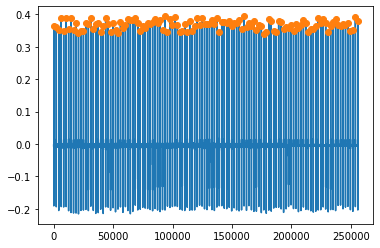

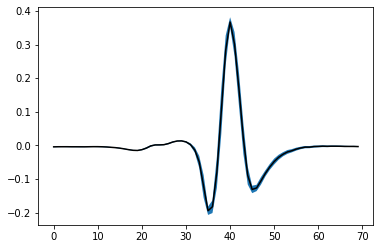

1
validation/002_Leticia_2018-01-21_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.009362170219421387
[7.76000000e+02 1.18041992e-01 2.50488281e-01]
0.031244647220296018
rs
0.4165332753001373
rs
0.8969491919857737
2 fish
2


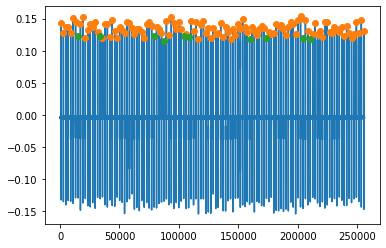

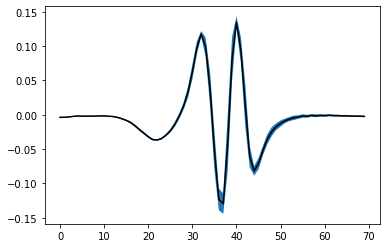

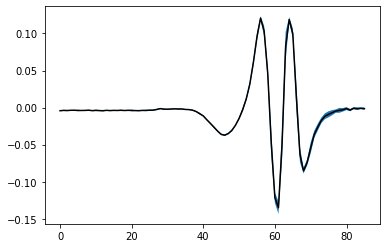

2
validation/003_Leticia_2018-01-21_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.010238732814788818
[1.72600000e+03 4.48303223e-02 2.74719238e-01]
0.019160207440910085
rs
1.0239622394606702
rs
0.001512056459003995
rs
0.0031966500749289156
1 fish
1


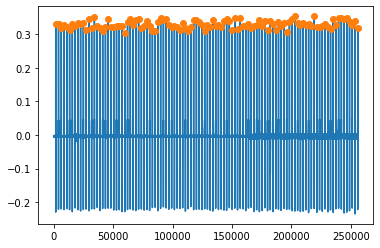

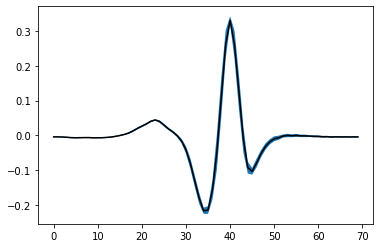

3
validation/004_Leticia_2018-01-21_Jorge_Molina_2_pulsefish.wav
0.0
extracting times
0.014103020906448365
[9.10000000e+01 2.41088867e-03 2.31933594e-02]
0.021229053681175034
rs
0.0022860837409968944
rs
0.03928084097994788
rs
1.1905747665516846
2 fish
2


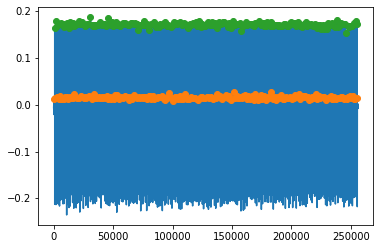

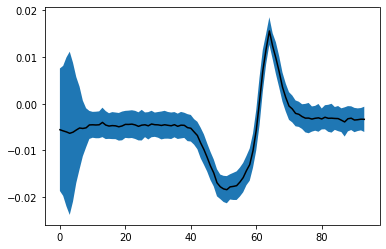

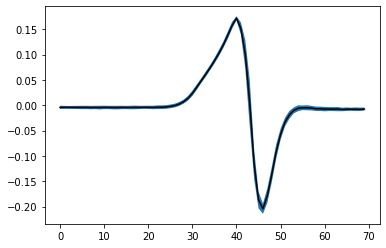

4
validation/005_Leticia_2018-01-21_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.008948273897171021
[1.50000000e+01 6.92749023e-03 2.08129883e-02]
0.028549870270760638
rs
0.10272654940659481
1 fish
1


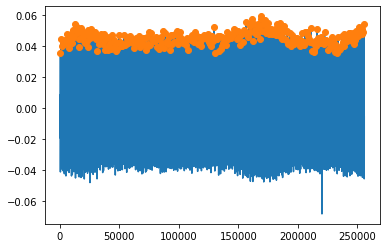

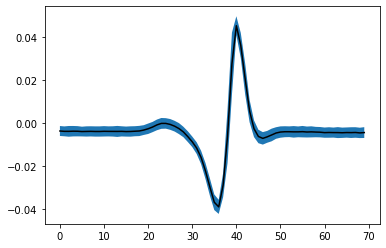

5
validation/006_Leticia_2018-01-21_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.009416297674179078
[4.40000000e+01 2.62451172e-03 1.54418945e-02]
0.011248211999821593
rs
0.00201291233405107
rs
0.013906610190401977
rs
0.6170191105954214
rs
0.004673141729923389
2 fish
2


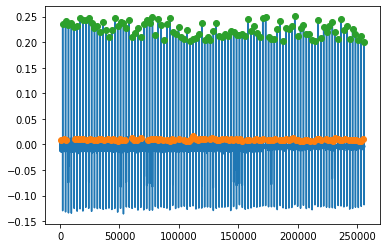

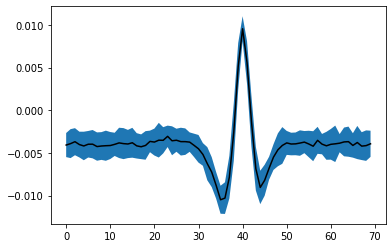

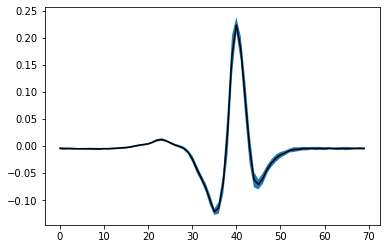

6
validation/007_Leticia_2018-01-21_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.00991371989250183
[1.03700000e+03 2.48413086e-02 1.72698975e-01]
0.027635478982575016
rs
0.8291668522012401
rs
0.006017385150585437
rs
0.004790830165965349
2 fish
2


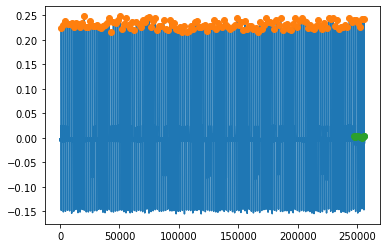

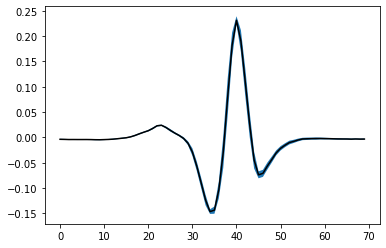

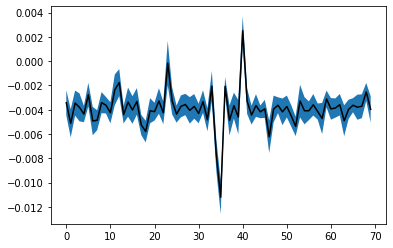

7
validation/008_Leticia_2018-01-21_Jorge_Molina_2_pulsefish.wav
0.0
extracting times
0.0174925000667572
[458.           0.61190796   1.27090454]
0.03093424449815085
rs
3.0948693488379417
rs
0.168577133164449
2 fish
2


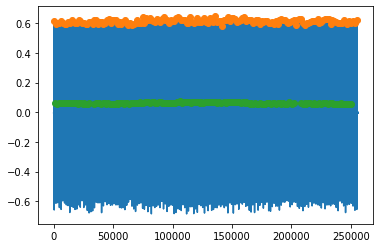

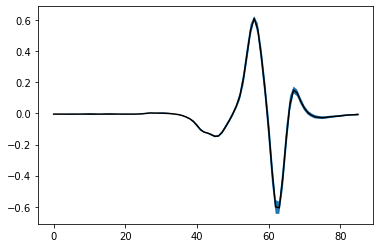

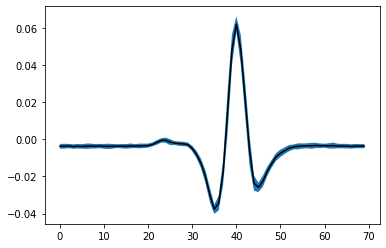

8
validation/009_Leticia_2018-01-21_Jorge_Molina_0_pulsefish.wav
0.0
extracting times
0.008575334787368775
[ 6.00000000e+00 -9.15527344e-05  9.00268555e-03]
0.017158787509772504
rs
0.021139105224800156
rs
0.0034520496914439954
rs
0.010617519299268137
2 fish
2


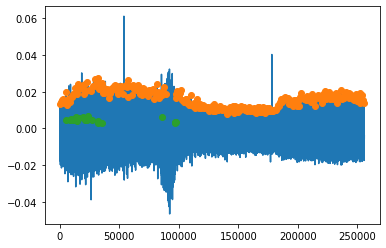

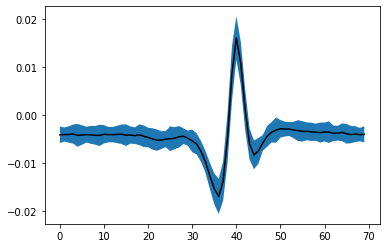

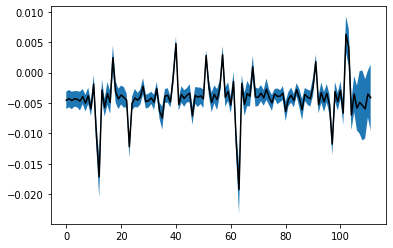

9
validation/010_Leticia_2018-01-21_Jorge_Molina_2_pulsefish.wav
0.0
extracting times
0.009281404972076416
[6.90000000e+01 5.85937500e-02 1.86889648e-01]
0.0265632231177382
rs
0.6108144531756841
rs
0.024256871826606855
2 fish
2


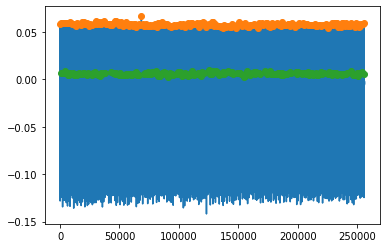

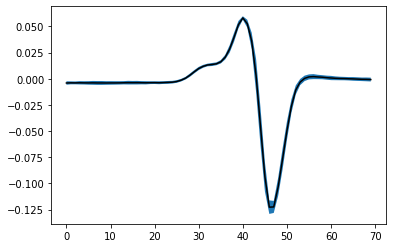

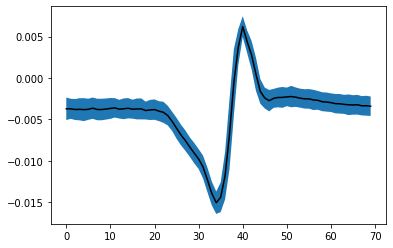

10
validation/011_Leticia_2018-01-21_Jorge_Molina_2_pulsefish.wav
0.0
extracting times
0.008254367351531983
[5.40000000e+02 8.08715820e-03 2.95715332e-02]
0.022437637352941603
rs
0.019737546132549296
rs
0.043099323512770175
rs
0.001563331663244593
2 fish
2


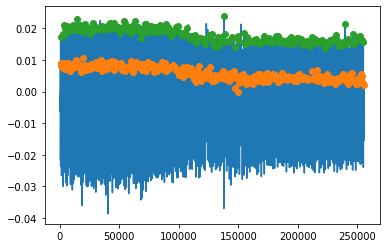

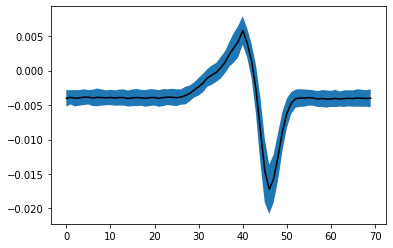

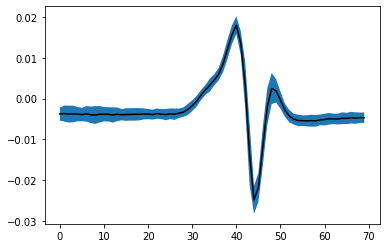

11
validation/014_Leticia_2018-01-21_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.009750967264175415
[2.95000000e+02 2.44140625e-04 4.26940918e-02]
0.027801503375825657
rs
0.1326407598081353
1 fish
1


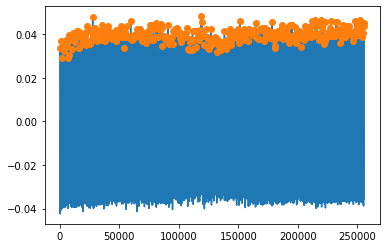

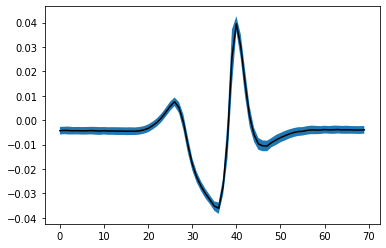

12
validation/015_Leticia_2018-01-21_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.01468057107925415
[1.45000000e+03 3.44207764e-01 6.49200439e-01]
0.02884029102227341
rs
1.6936539015959835
1 fish
1


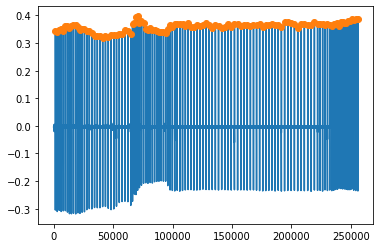

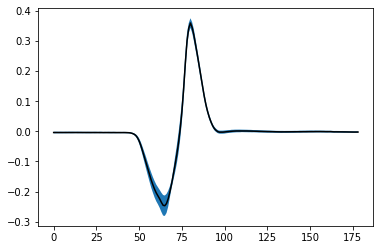

13
validation/016_Leticia_2018-01-21_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.010056817531585693
[3.96700000e+03 5.20019531e-02 1.95281982e-01]
0.001114734533975626
rs
0.6906837700041752
1 fish
1


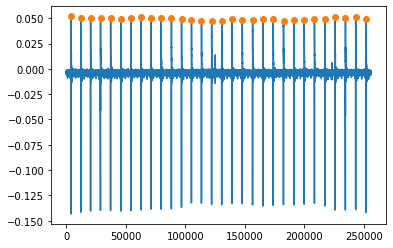

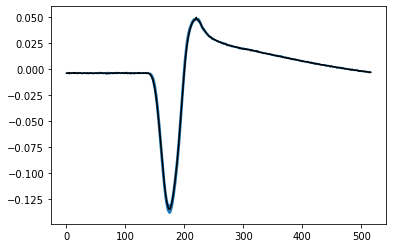

14
validation/017_Leticia_2018-01-21_Jorge_Molina_1_pulsefish_eel.wav
0.0
extracting times
0.026156437397003175
[4.18000000e+02 2.35595703e-02 8.87145996e-02]
0.031238484771003317
rs
0.10269552785462525
rs
0.002014770895473396
rs
0.002804185524582242
1 fish
1


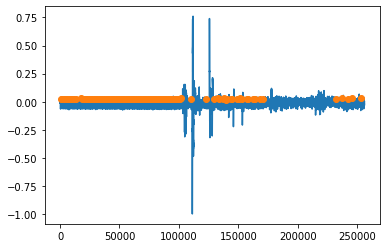

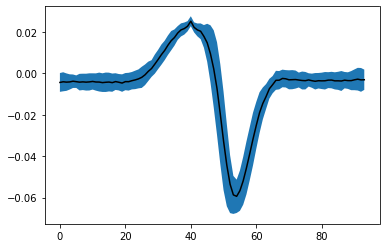

15
validation/018_Leticia_2018-01-21_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.011862188816070556
[5.73000000e+02 1.10839844e-01 1.57165527e-01]
0.028643120926193102
rs
0.6499041399232894
1 fish
1


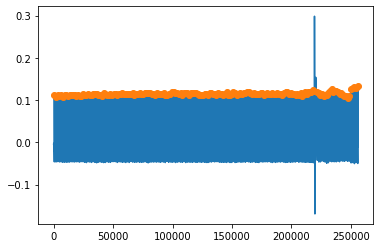

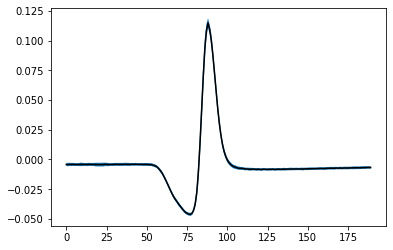

16
validation/019_Leticia_2018-01-21_Jorge_Molina_2_pulsefish.wav
0.0
extracting times
0.045136875152587894
[6.66500000e+03 1.73950195e-02 4.64782715e-02]
0.029138398250458792
rs
0.08165926737814433
1 fish
1


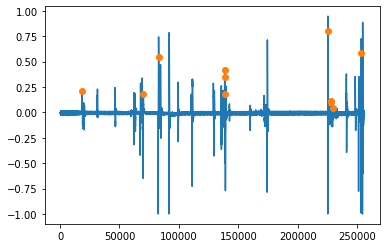

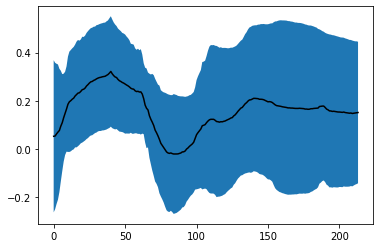

17
validation/021_Leticia_2018-01-19_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.021984485864639282
[1.40000000e+03 1.43524170e-01 8.53668213e-01]
0.03039525667336028
rs
10.494188929394776
rs
2.690707323979067
2 fish
2


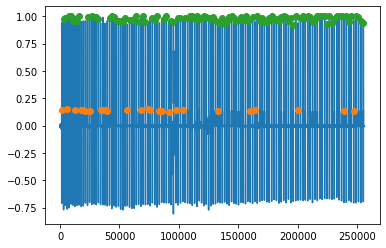

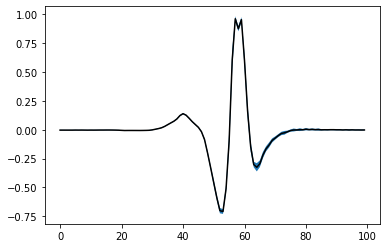

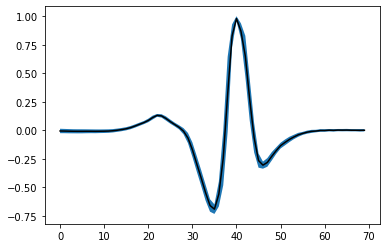

18
validation/022_Leticia_2018-01-19_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.2034567413330078
[1.37400000e+03 9.75250244e-01 1.97525024e+00]
0.022542870423139273
rs
5.488763206865297
rs
9.672361943278018
rs
11.097355235823468
rs
10.869680017993963
4 fish
4


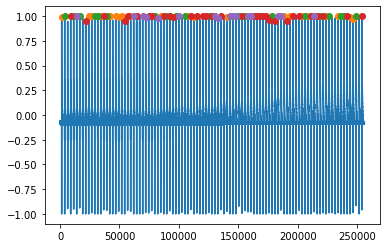

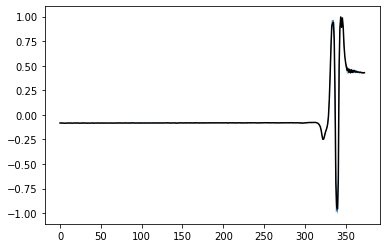

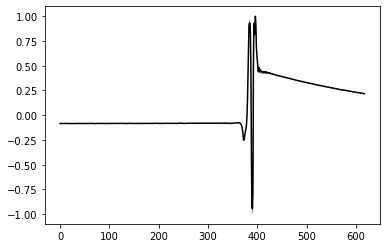

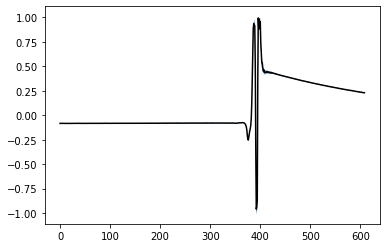

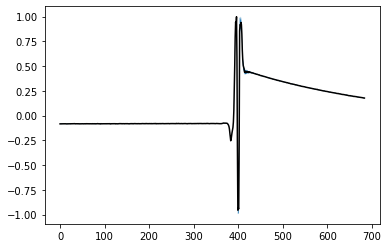

19
validation/023_Leticia_2018-01-19_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.012174857139587403
[5.10000000e+01 6.37817383e-03 2.27661133e-02]
0.02144983562583528
rs
0.008782389490285362
rs
0.00456651960390517
rs
0.5721395842971975
2 fish
2


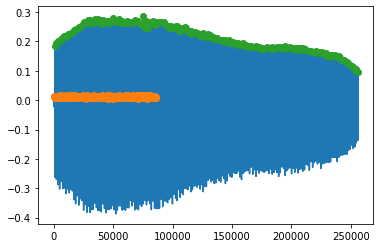

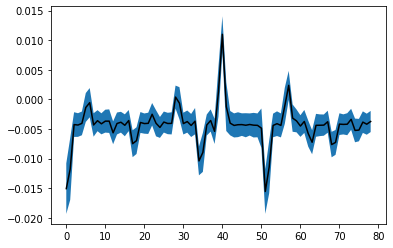

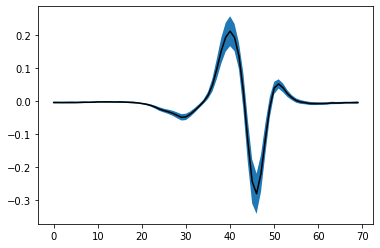

20
validation/024_Leticia_2018-01-19_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.014851834058761598
[3.24000000e+02 6.77185059e-02 2.70446777e-01]
0.02225754482555206
rs
1.2910830206819133
rs
0.005699748076474945
rs
0.009555464326569832
rs
0.008534730136348158
4 fish
4


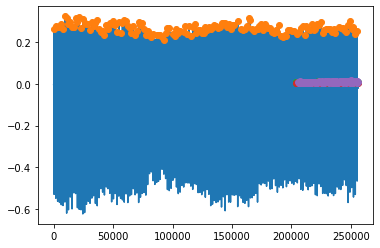

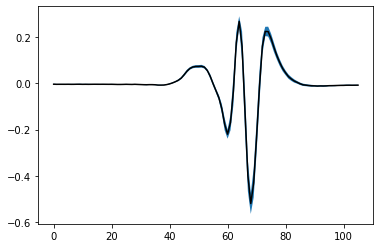

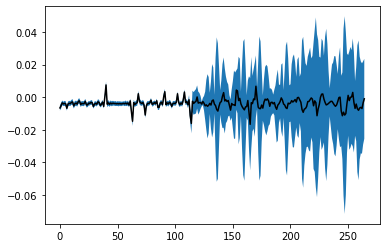

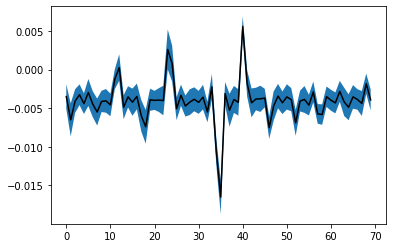

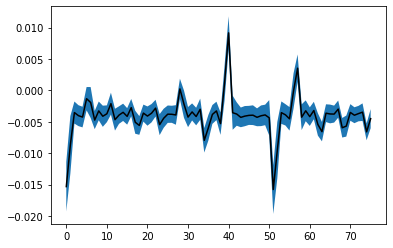

21
validation/025_Leticia_2018-01-19_Jorge_Molina_1_pulsefish_eel.wav
0.0
extracting times
0.011623448371887207
[3.22400000e+03 9.41772461e-02 1.49169922e-01]
0.0247109131488817
rs
0.12452195542743813
1 fish
1


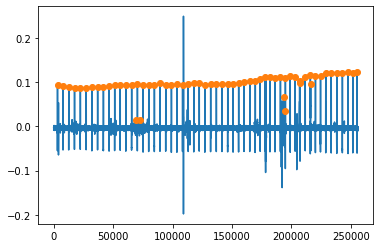

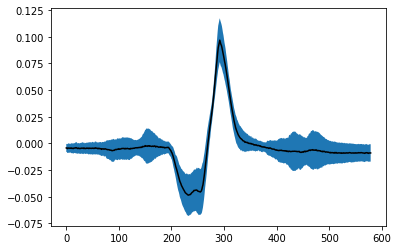

22
validation/026_Leticia_2018-01-19_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.012263306140899658
[7.4000000e+01 7.5378418e-03 3.0670166e-02]
0.01801288072660059
rs
0.009915079098440112
rs
0.006007170962216214
rs
0.847992684894875
rs
0.01150467352776339
rs
0.013981074989169827
5 fish
5


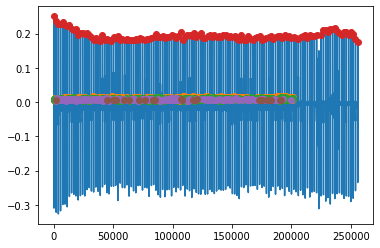

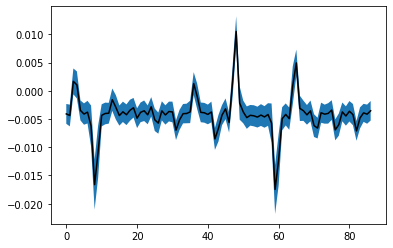

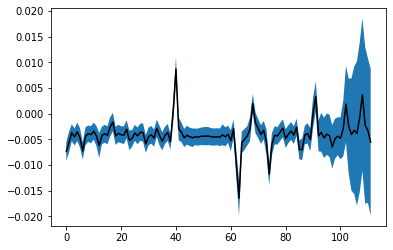

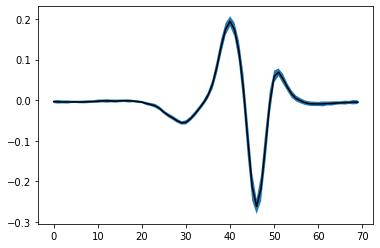

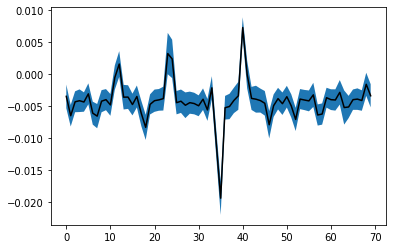

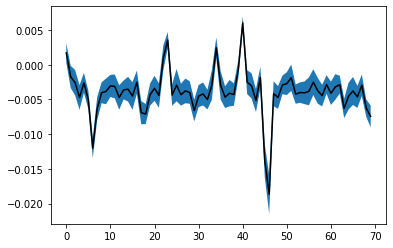

23
validation/027_Leticia_2018-01-19_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.008880352020263672
[5.20000000e+01 2.31933594e-03 1.88293457e-02]
0.01734950651748065
rs
0.0023184420977154776
rs
0.20694659204543078
1 fish
1


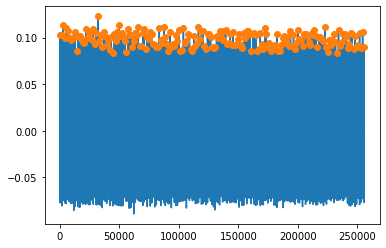

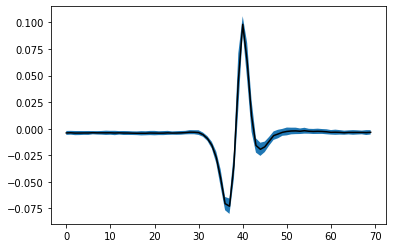

24
validation/028_Leticia_2018-01-19_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.012484668493270875
[7.00000000e+01 1.22070312e-03 3.68652344e-02]
0.02235397145916532
rs
1.4235172948103831
rs
0.0064548606426758585
rs
0.011834411595644549
rs
0.012039779847654275
4 fish
4


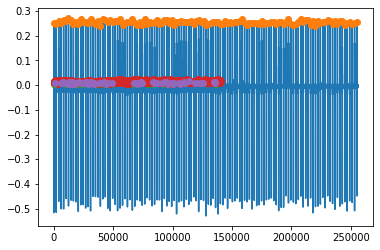

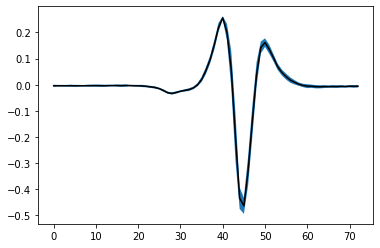

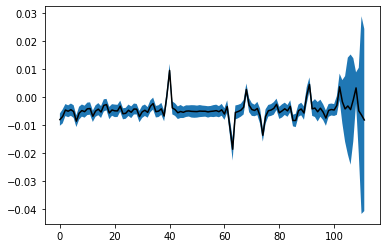

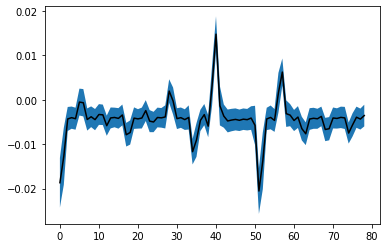

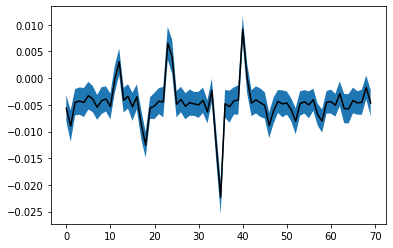

25
validation/029_Leticia_2018-01-19_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.01504530906677246
[6.         0.5715332  0.71963501]
0.03095735991909724
rs
2.6034423171016434
1 fish
1


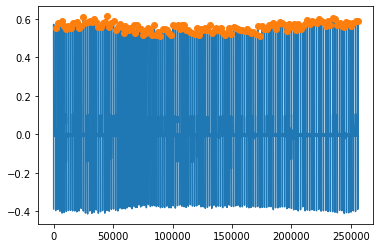

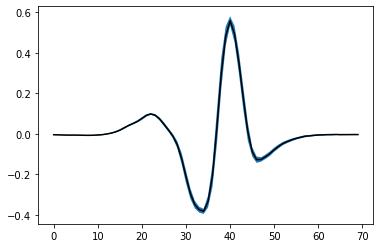

26
validation/030_Leticia_2018-01-19_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.012677691221237183
[1.21400000e+03 5.18493652e-02 3.39569092e-01]
0.0208892815807356
rs
1.6705416680782235
rs
0.013894375875914888
rs
0.011172827256255671
rs
0.0068759004007489235
4 fish
4


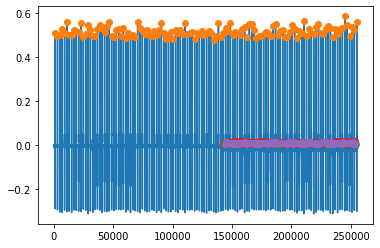

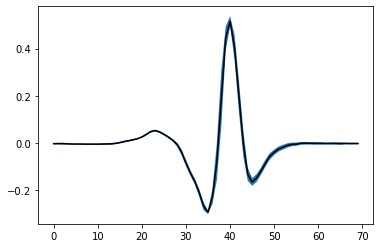

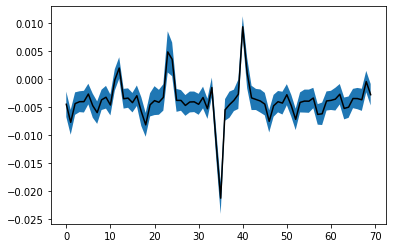

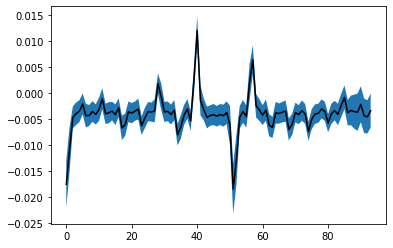

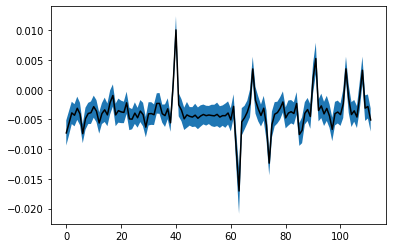

27
validation/031_Leticia_2018-01-19_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.012406577825546265
[1.66200000e+03 2.56652832e-02 3.08898926e-01]
0.031002070438494806
rs
1.5879558068172581
1 fish
1


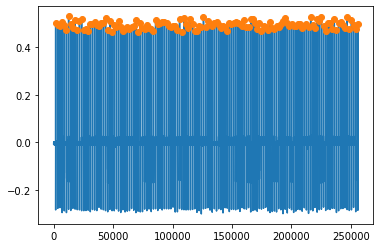

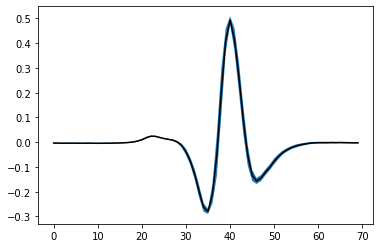

28
validation/032_Leticia_2018-01-22_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.013209276914596557
[3.89000000e+02 6.62231445e-03 2.60314941e-02]
0.022714933191619904
rs
0.01640932386839094
rs
2.4991008522108227
rs
0.008972773907595473
rs
0.01852235021334668
4 fish
4


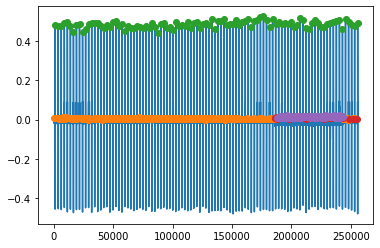

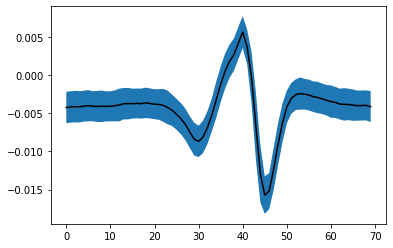

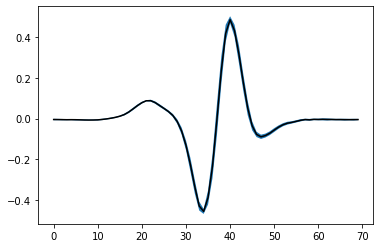

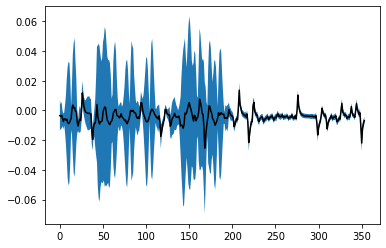

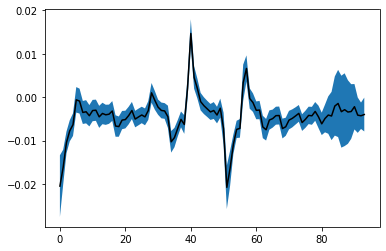

29
validation/033_Leticia_2018-01-22_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.013288423299789428
[5.08000000e+02 2.42309570e-02 3.49914551e-01]
0.02960270996867038
rs
0.9789626924610717
rs
0.007608327397348084
rs
0.013174215314374243
3 fish
3


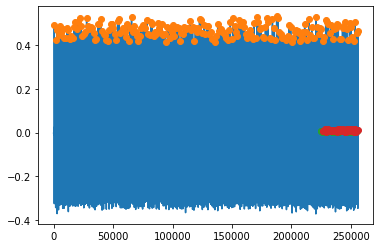

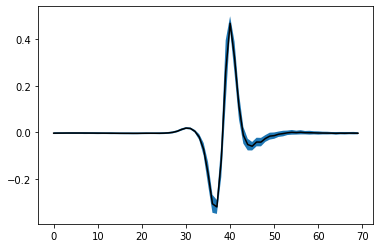

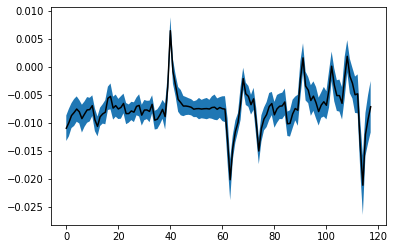

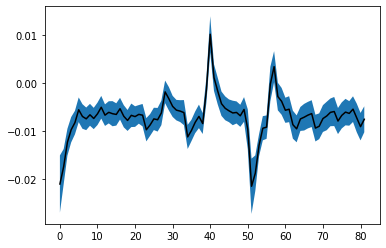

30
validation/034_Leticia_2018-01-22_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.014475218534469604
[2.35500000e+03 4.91333008e-03 3.13720703e-02]
0.031241370373066256
rs
2.7968979219875902
1 fish
1


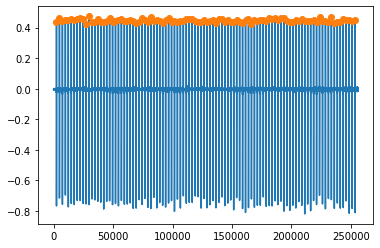

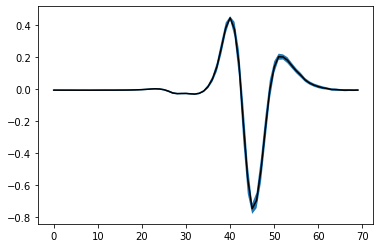

31
validation/035_Leticia_2018-01-20_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.010448068141937257
[1.55800000e+03 1.09558105e-02 1.39251709e-01]
0.029615408419349985
rs
0.879865284558623
rs
0.0036886250839546133
1 fish
1


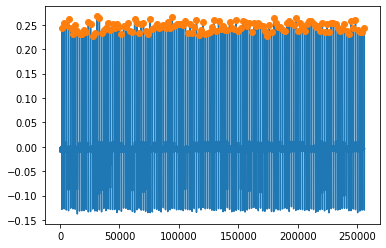

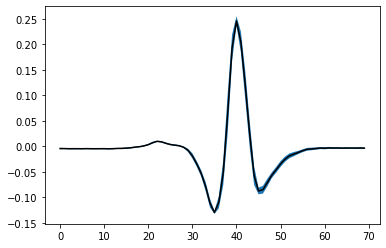

32
validation/036_Leticia_2018-01-20_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.01016924238204956
[2.29000000e+02 3.03649902e-02 2.21832275e-01]
0.019913456293036084
rs
0.9364395559469132
rs
0.001941414175154102
1 fish
1


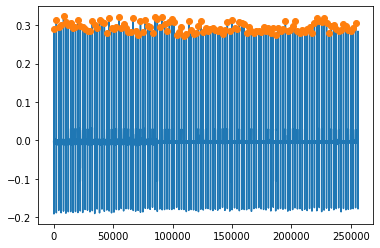

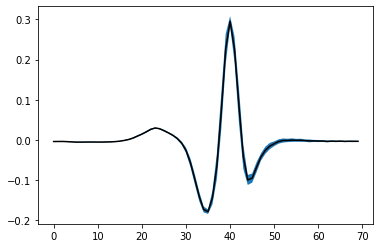

33
validation/037_Leticia_2018-01-20_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.009237980842590332
[1.72800000e+03 8.91113281e-03 1.34918213e-01]
0.02094530373796832
rs
0.5977477710051363
rs
0.0017258478107280986
1 fish
1


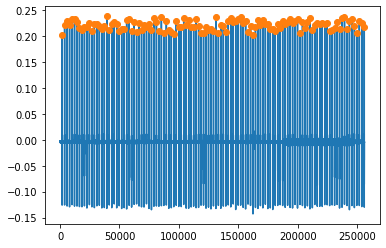

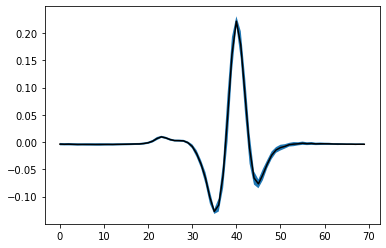

34
validation/038_Leticia_2018-01-20_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.008837252140045167
[1.27600000e+03 6.43005371e-02 1.84814453e-01]
0.01752683643252684
rs
0.37846301356442097
rs
0.0017783960079163622
1 fish
1


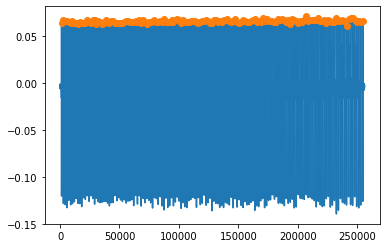

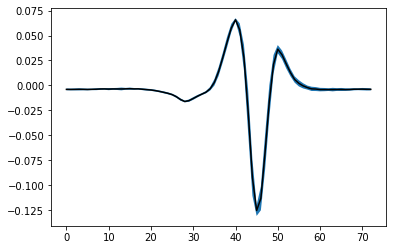

35
validation/039_Leticia_2018-01-20_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.008287781000137329
[1.25500000e+03 2.96020508e-02 5.99670410e-02]
0.026963934450501884
rs
0.12434580334237319
rs
0.00104311032500072
1 fish
1


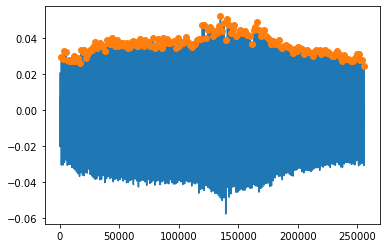

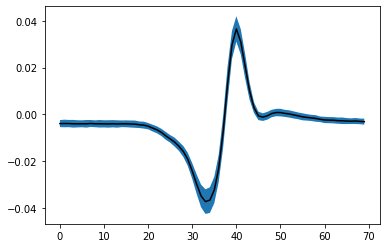

36
validation/041_Leticia_2018-01-20_Jorge_Molina_1_pulsefish_eel.wav
0.0
extracting times
0.011571738958358765
[6.97000000e+02 1.85241699e-02 5.00488281e-02]
0.029081306196522702
rs
0.09931306415034102
rs
0.0004224624773597933
1 fish
1


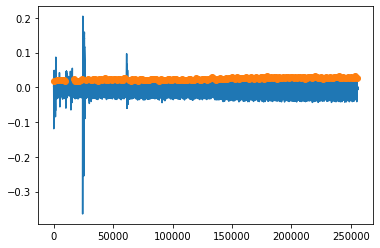

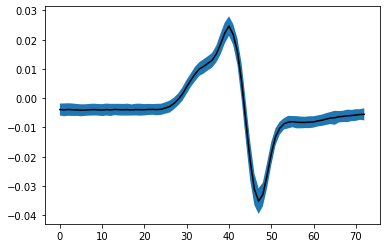

37
validation/042_Leticia_2018-01-20_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.020970324754714966
[1.29100000e+03 1.89636230e-01 1.06478882e+00]
0.030969584167748008
rs
3.6533695418264656
1 fish
1


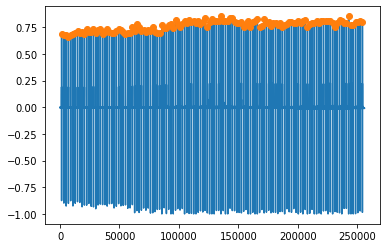

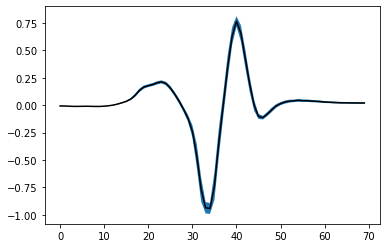

38
validation/043_Leticia_2018-01-20_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.009715229034423829
[4.35000000e+02 3.17993164e-02 1.90917969e-01]
0.030885295844726036
rs
0.7645415108431742
1 fish
1


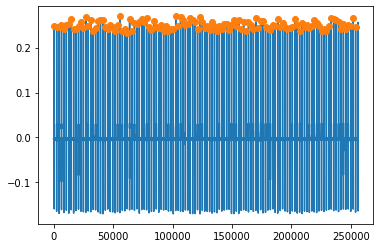

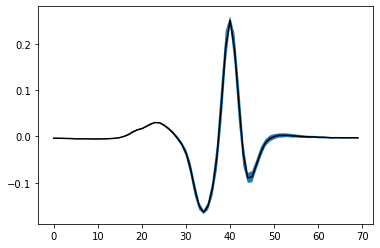

39
validation/044_Leticia_2018-01-20_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.010203489303588867
[1.32300000e+03 1.54907227e-01 3.46893311e-01]
0.017502985916929586
rs
0.6152124694342012
rs
0.0022655692719832504
1 fish
1


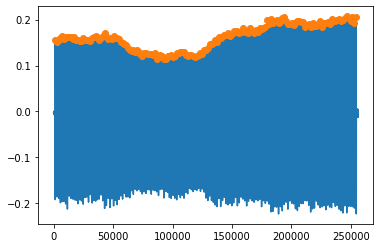

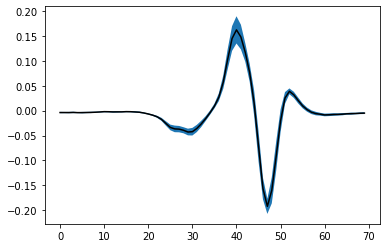

40
validation/045_Leticia_2018-01-20_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.009512028455734253
[1.23000000e+02 4.56848145e-02 9.86633301e-02]
0.030307702965158324
rs
0.26153883500532055
1 fish
1


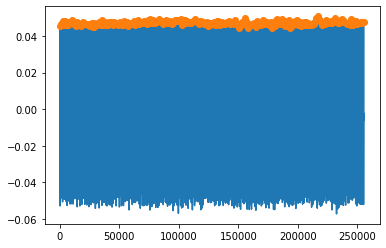

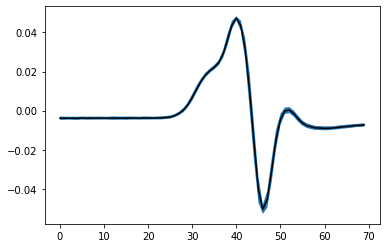

41
validation/047_Leticia_2018-01-20_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.011253438711166382
[2.91500000e+03 1.40777588e-01 2.07244873e-01]
0.00502274498386097
rs
1.3552611274308313
1 fish
1


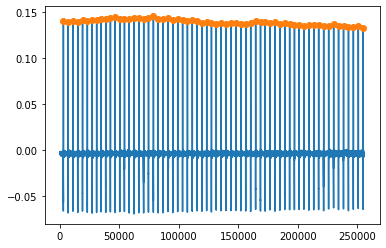

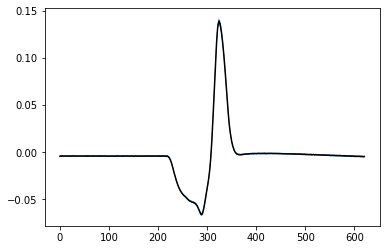

42
validation/049_Leticia_2018-01-20_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.014205779075622559
[8.45000000e+02 1.69647217e-01 2.60131836e-01]
0.002751403776348804
rs
3.1763608492336344
1 fish
1


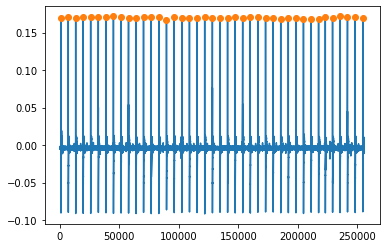

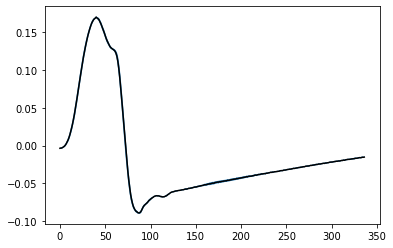

43
validation/050_Leticia_2018-01-20_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.011282039642333984
[3.80000000e+01 1.37329102e-03 1.45568848e-02]
0.022410294117834278
rs
0.002149126736780701
rs
0.9868851527440008
1 fish
1


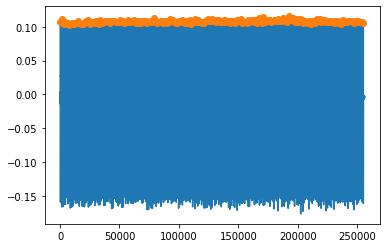

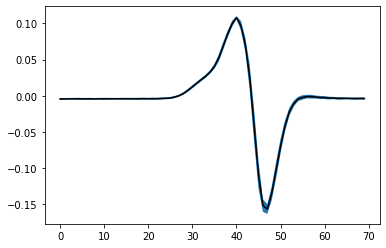

44
validation/051_Leticia_2018-01-20_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.011688912153244019
[2.59700000e+03 1.78314209e-01 2.80090332e-01]
0.000979141432601534
rs
3.5680661506777613
1 fish
1


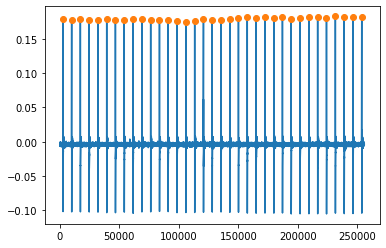

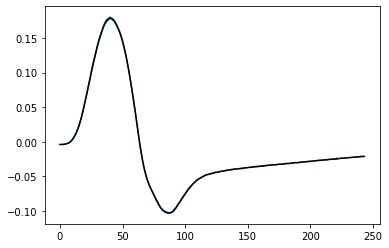

45
validation/052_Leticia_2018-01-20_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.010433754682540894
[4.25000000e+02 8.30078125e-02 2.33673096e-01]
0.030786223456218918
rs
1.232801188453757
1 fish
1


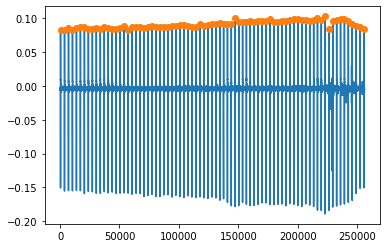

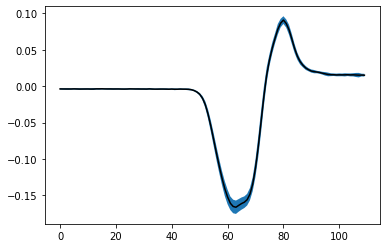

46
validation/053_Leticia_2018-01-20_Jorge_Molina_2_pulsefish.wav
0.0
extracting times
0.010526463270187377
[4.76000000e+02 4.68139648e-02 1.11328125e-01]
0.029638266865162778
rs
0.18523018376239084
rs
0.004677325138169411
rs
0.34429116294591006
rs
0.0022069054401935646
2 fish
2


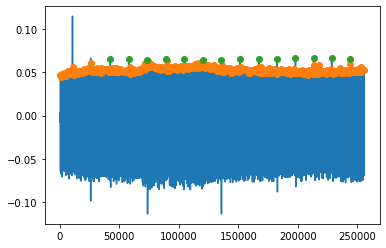

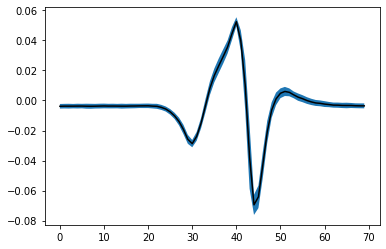

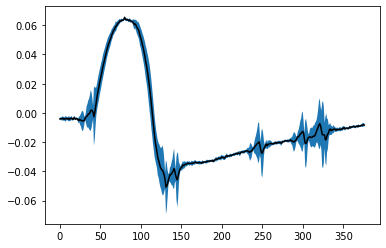

47
validation/054_Leticia_2018-01-20_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.008871443986892701
[1.20000000e+02 1.15966797e-03 1.04980469e-02]
0.022847290890857252
rs
0.0011732962211304019
rs
0.12436771716239937
1 fish
1


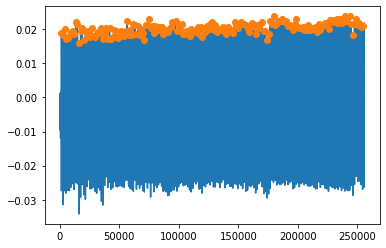

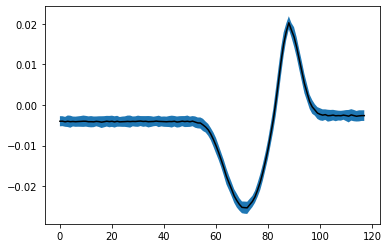

48
validation/055_Leticia_2018-01-20_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.01375721025466919
[1.47100000e+03 2.00561523e-01 3.43841553e-01]
0.0027980886339956405
rs
3.539752521230208
1 fish
1


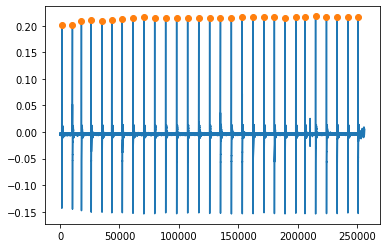

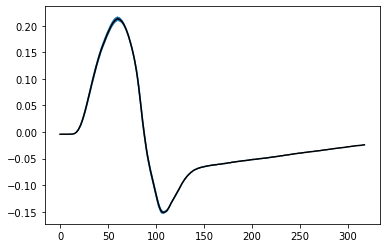

49
validation/056_Leticia_2018-01-20_Jorge_Molina_2_pulsefish.wav
0.0
extracting times
0.009031023025512695
[ 1.18000000e+02 -2.13623047e-04  1.28784180e-02]
0.021169683297069787
rs
0.530117232332283
rs
0.001956568781231505
rs
0.011576612372542353
rs
0.005799956024847621
3 fish
3


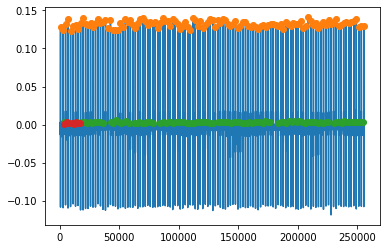

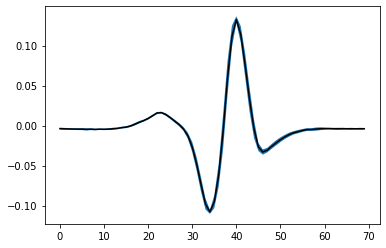

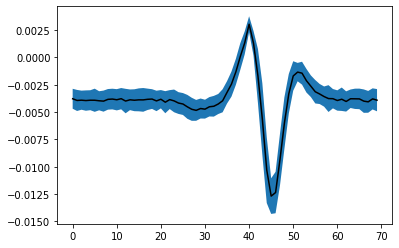

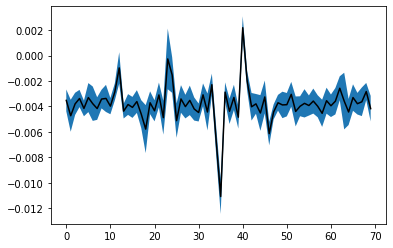

50
validation/057_Leticia_2018-01-20_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.012222982406616211
[3.98000000e+02 2.43652344e-01 6.83410645e-01]
0.030118563127277426
rs
1.7150932090266593
1 fish
1


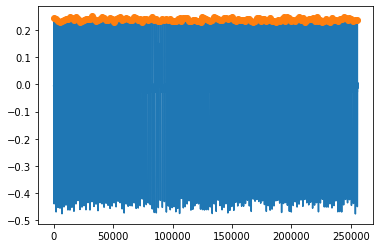

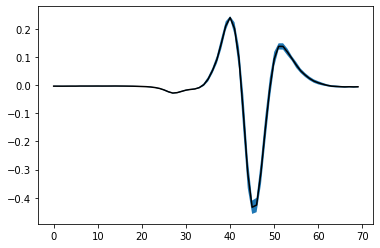

51
validation/058_Leticia_2018-01-20_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.012105063915252685
[2.54000000e+02 3.81774902e-02 3.10638428e-01]
0.019242064250109374
rs
1.6241225633615959
rs
0.0028940235569779485
rs
0.005750842556021251
2 fish
2


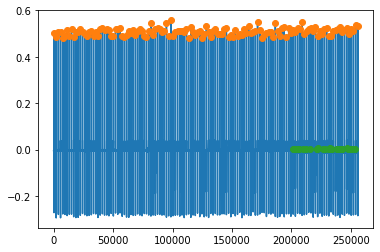

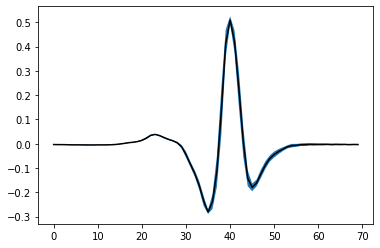

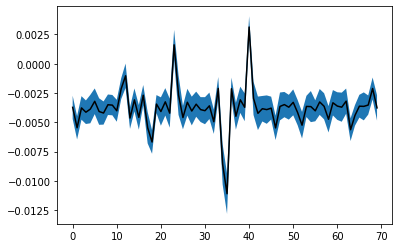

52
validation/059_Leticia_2018-01-20_Jorge_Molina_2_pulsefish.wav
0.0
extracting times
0.01225699520111084
[3.71000000e+02 2.24609375e-02 7.04040527e-02]
0.016368366942880932
rs
0.06446210272688647
rs
0.0018687453429288988
rs
1.1409397425563732
2 fish
2


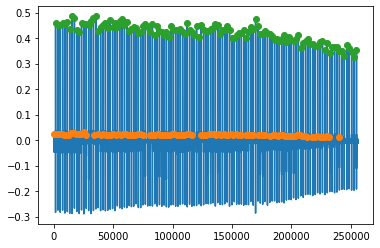

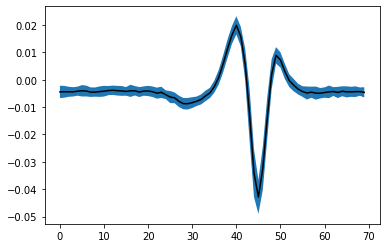

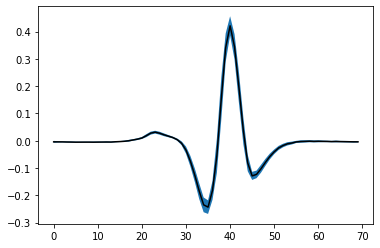

53
validation/060_Leticia_2018-01-20_Jorge_Molina_1_pulsefish.wav
0.0
extracting times
0.00854747724533081
[ 8.00000000e+00 -9.15527344e-05  1.10473633e-02]
0.01800105973550339
rs
0.002095110770544624
rs
0.17615546480092772
1 fish
1


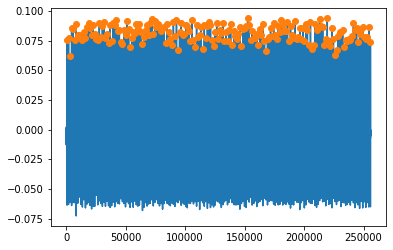

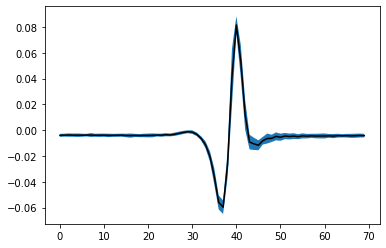

54
validation/061_Leticia_2019-10-14_Jaqcui_Goebl_3_pulsefish.wav
0.0
extracting times
0.09784148383140565
[29.          0.04901123  0.15197754]
0.031168687775559818
rs
0.8405836188651671
rs
0.3495305420325168
2 fish
2


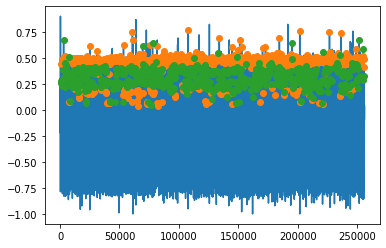

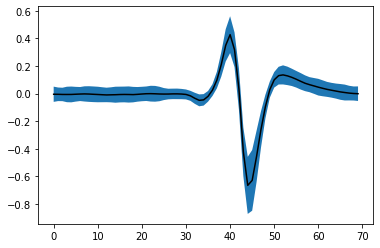

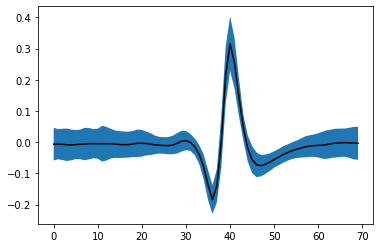

55
validation/063_Leticia_2019-10-14_Jaqcui_Goebl_1_pulsefish.wav
0.0
extracting times
0.01689306044578552
[7.90000000e+01 7.20214844e-03 2.59399414e-02]
0.026419158803737606
rs
1.4322834537922624
1 fish
1


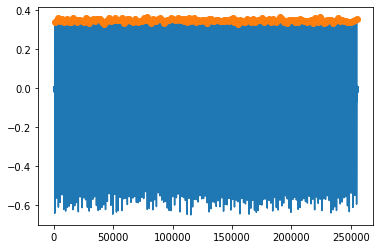

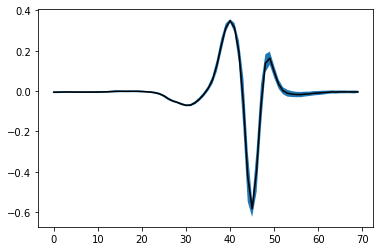

56
validation/064_Leticia_2019-10-14_Jaqcui_Goebl_2_pulsefish.wav
0.0
extracting times
0.016460298776626588
[5.86000000e+02 4.09240723e-02 2.66601562e-01]
0.02952278134891245
rs
1.1406727718727654
rs
0.09590371280214026
2 fish
2


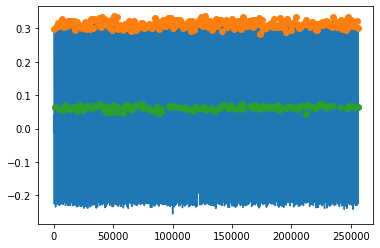

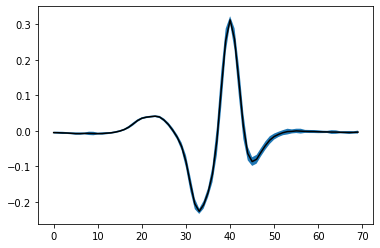

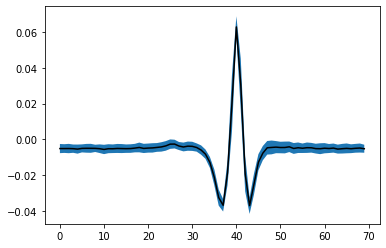

57
58
validation/067_Leticia_2019-10-14_Jaqcui_Goebl_2_pulsefish.wav
0.0
extracting times
0.046025964975357055
[29.          0.05984497  0.14297485]
0.031200030899362404
rs
0.07164374096556377
rs
3.1616782266037697
rs
0.08025771230057015
rs
0.06423933429373761
4 fish
4


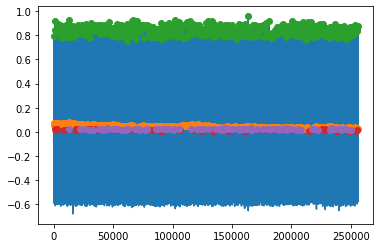

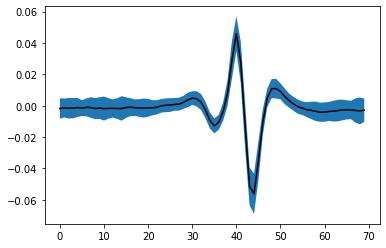

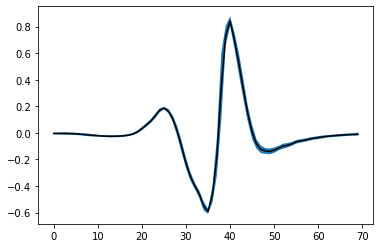

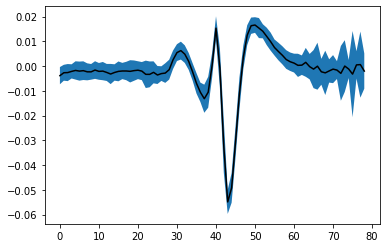

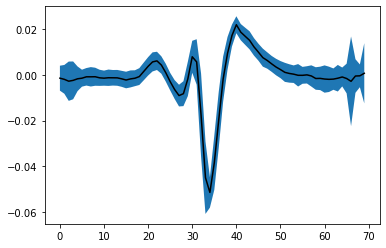

59
validation/068_Leticia_2019-10-14_Jaqcui_Goebl_1_pulsefish.wav
0.0
extracting times
0.008275294303894043
[1.76000000e+02 4.42504883e-03 1.22070312e-02]
0.027546020900783633
rs
0.37735839645377917
rs
0.009195548199008597
rs
0.013286802483267683
rs
0.00885677797225173
4 fish
4


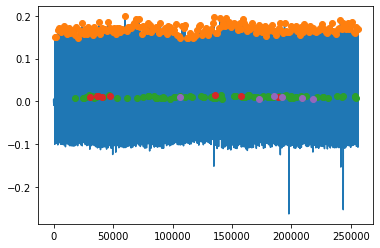

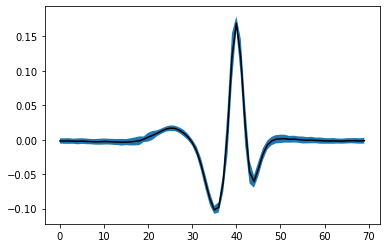

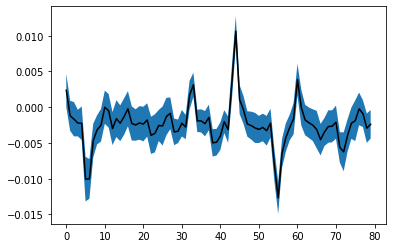

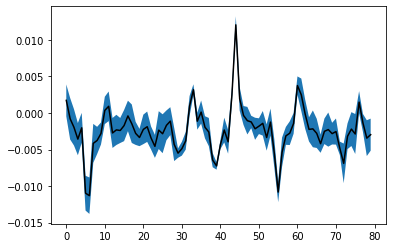

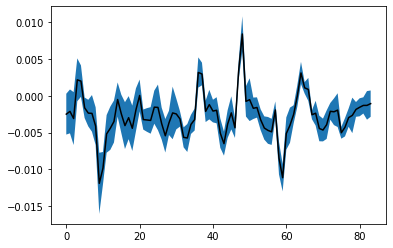

60
61
validation/070_Leticia_2019-10-14_Jaqcui_Goebl_2_pulsefish.wav
0.0
extracting times
0.0066081626415252686
[1.35000000e+02 4.26025391e-02 7.83691406e-02]
0.030052605341626196
rs
0.14430051799536323
rs
0.09904919398125621
2 fish
2


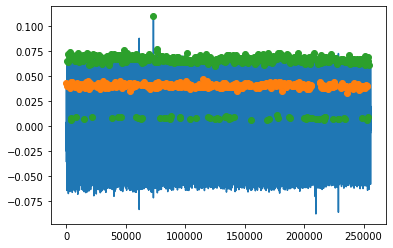

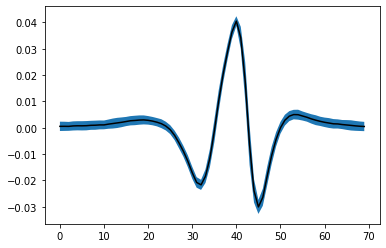

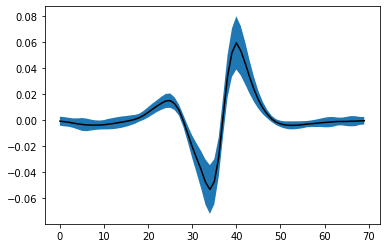

62
validation/072_Leticia_2019-10-14_Jaqcui_Goebl_1_pulsefish.wav
0.0
extracting times
0.005286992073059082
[2.53000000e+02 6.35070801e-02 2.93365479e-01]
0.02671614916806562
rs
0.8490516420865138
1 fish
1


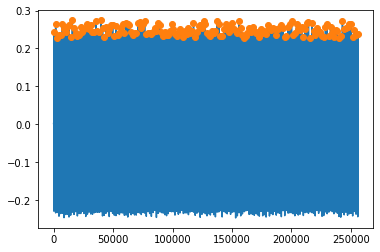

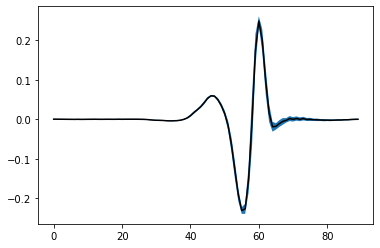

63
validation/073_Leticia_2019-10-14_Jaqcui_Goebl_1_pulsefish_eel.wav
0.0
extracting times
0.0036635632514953613
[6.30000000e+01 1.98364258e-03 7.26318359e-03]
0.02987539545908824
rs
0.019371670323695536
rs
0.0020238173371757567
rs
0.0006573787611914465
1 fish
1


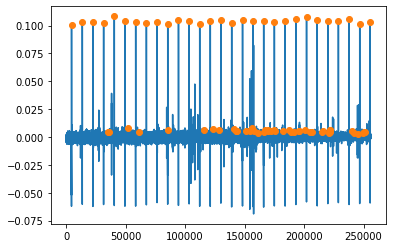

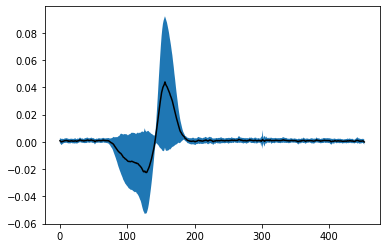

64
validation/075_Leticia_2019-10-14_Jaqcui_Goebl_0_pulsefish_eel.wav
0.0
extracting times
0.356812424659729
[2.19350000e+04 9.56542969e-01 1.95654297e+00]
0.006266848590072669
rs
13.137597037199983
1 fish
1


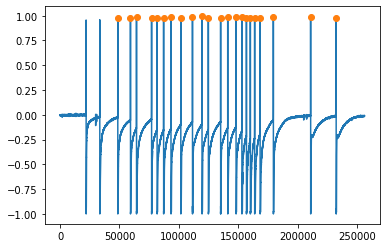

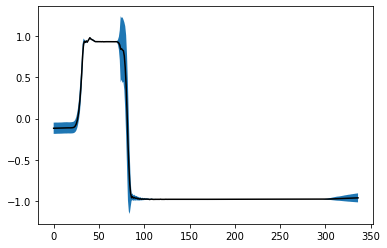

65
validation/076_Leticia_2019-10-14_Jaqcui_Goebl_1_pulsefish.wav
0.0
extracting times
0.011092287778854371
[3.98000000e+02 2.09655762e-02 5.11474609e-02]
0.025178251217839537
rs
0.0646379396401262
rs
0.0048320551257943255
1 fish
1


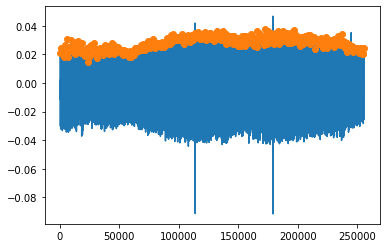

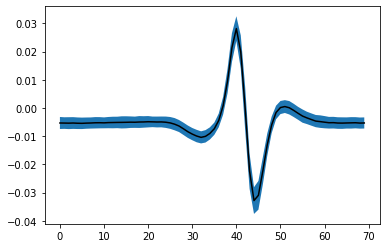

66
67
validation/079_Leticia_2019-10-14_Jaqcui_Goebl_3_pulsefish.wav
0.0
extracting times
0.044592250108718874
[75.          0.25714111  0.40963745]
0.031043393042021247
rs
0.3562018940231842
rs
0.04526993758183409
2 fish
2


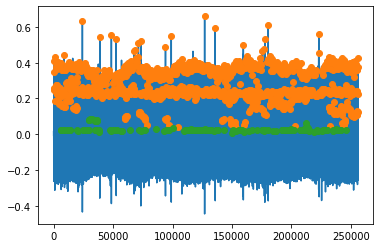

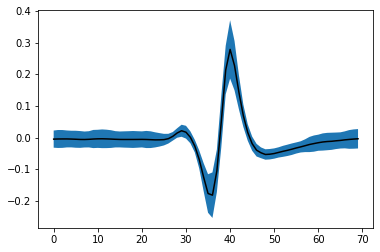

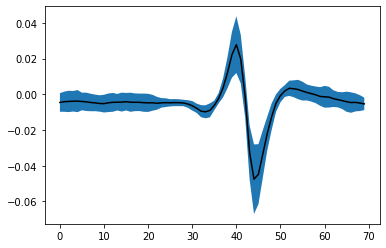

68
validation/080_Leticia_2019-10-15_Jaqcui_Goebl_1_pulsefish.wav
0.0
extracting times
0.010417938947677612
0 fish
0


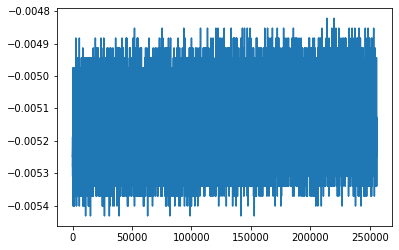

69
70
validation/082_Leticia_2019-10-15_Jaqcui_Goebl_1_pulsefish.wav
0.0
extracting times
0.012579087018966675
[ 1.08000000e+02 -5.73730469e-03  1.66625977e-02]
0.015470135427056341
rs
0.0035772095761191797
rs
0.05242983173489405
1 fish
1


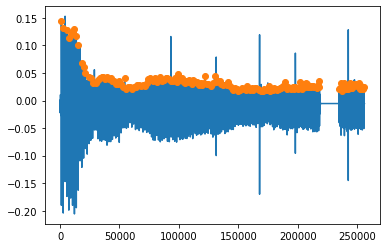

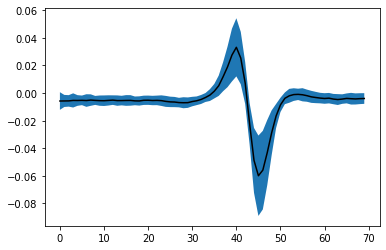

71
72
validation/085_Leticia_2019-10-15_Jaqcui_Goebl_1_pulsefish.wav
0.0
extracting times
0.013381575107574463
[1.90000000e+01 4.63867188e-03 2.45361328e-02]
0.027676637115249317
rs
0.004471138754969083
rs
0.008056453280083123
rs
0.4007564430806724
rs
0.010083074937385906
3 fish
3


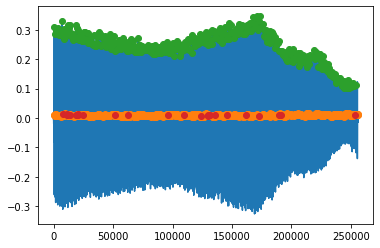

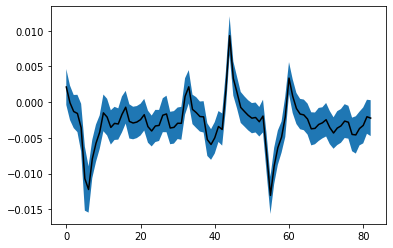

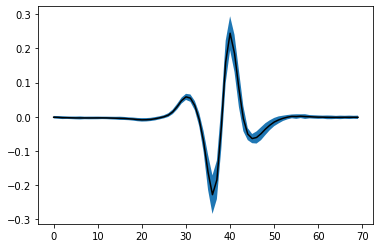

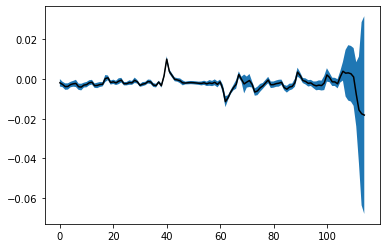

73
validation/086_Leticia_2019-10-15_Jaqcui_Goebl_1_pulsefish.wav
0.0
extracting times
0.021529427766799926
[291.           0.68539429   1.10684204]
0.031040652601722004
rs
1.5329030304750884
1 fish
1


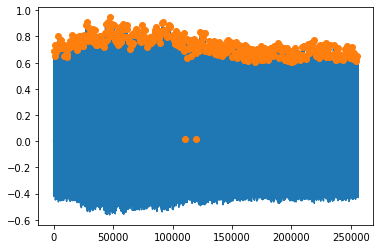

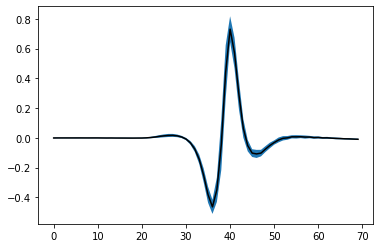

74
validation/087_Leticia_2019-10-15_Jaqcui_Goebl_1_pulsefish.wav
0.0
extracting times
0.006564624786376953
[3.90000000e+01 1.00708008e-03 6.92749023e-03]
0.016904476713947247
rs
1.6340683897463288
1 fish
1


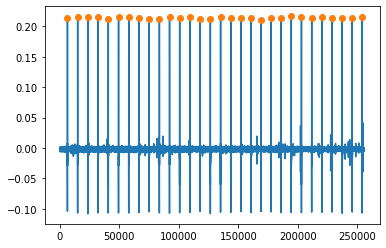

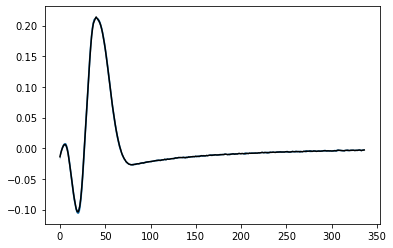

75
validation/088_Leticia_2019-10-15_Jaqcui_Goebl_2_pulsefish.wav
0.0
extracting times
0.018792972087860106
[2.80000000e+01 1.31835938e-02 3.05175781e-02]
0.031242194538573794
rs
0.21356590155546368
rs
0.41066470154249024
2 fish
2


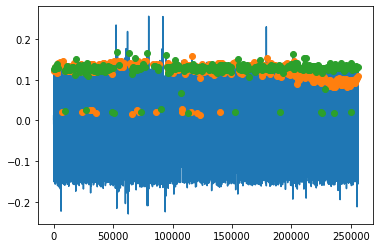

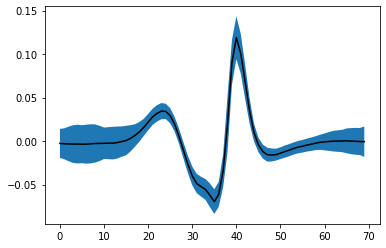

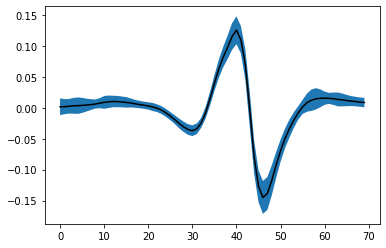

76
validation/089_Leticia_2019-10-15_Jaqcui_Goebl_1_pulsefish.wav
0.0
extracting times
0.00801328444480896
[7.70000000e+01 8.54492188e-03 1.16577148e-02]
0.029744505056988387
rs
0.8024816617754141
rs
0.001310868159782527
1 fish
1


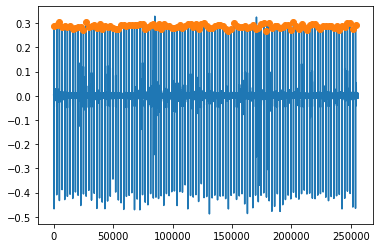

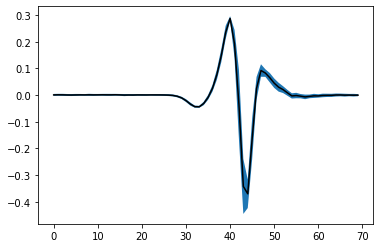

77
validation/091_Leticia_2019-10-15_Jaqcui_Goebl_2_pulsefish.wav
0.0
extracting times
0.048592372179031375
[19.          0.06210327  0.38449097]
0.03124470677922214
rs
0.3632009129492912
rs
1.0101055261883873
rs
0.1241965128286693
3 fish
3


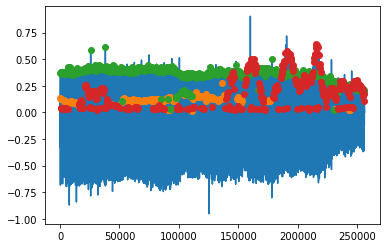

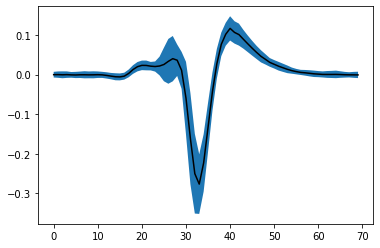

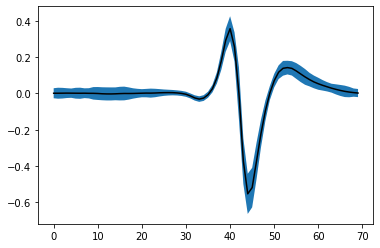

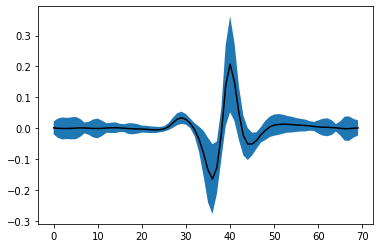

78
validation/093_Lake-Nabugabo-Uganda_2019-0x-0x_Stefan_Mucha_1_pulsefish.wav
0.0
extracting times
0.012966886978149414
[2.85200000e+03 1.52832031e-01 2.98095703e-01]
0.009165395754474396
rs
0.49584115118706606
rs
0.002269575623206454
1 fish
1


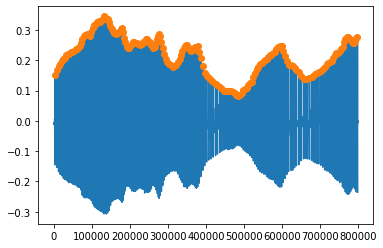

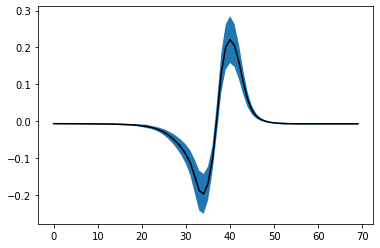

79
validation/094_Lake-Nabugabo-Uganda_2019-0x-0x_Stefan_Mucha_1_pulsefish.wav
0.0
extracting times
0.0045880181121826175
[3.82000000e+02 2.19726562e-03 1.11694336e-02]
0.009978531786772722
rs
0.17936996292690613
rs
0.12275759506193325
2 fish
2


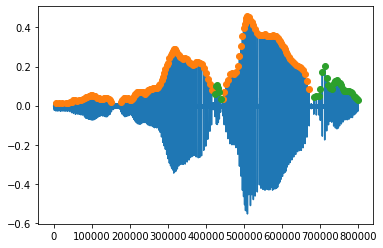

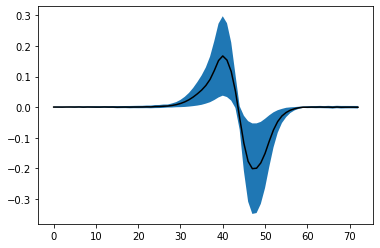

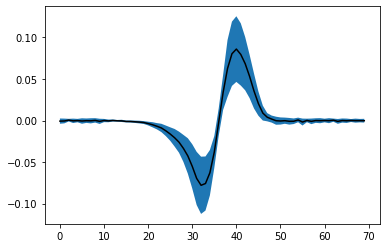

80
validation/096_Panama_2014-05-17_Ruediger_Krahe_2_pulsefish.wav
0.0
extracting times
0.805092755317688
[1.06000000e+03 9.99969482e-01 1.86013794e+00]
0.02929529565657351
rs
8.5767364301745
rs
2.3399776120657836
rs
19.794976662058257
rs
20.59474402161833
rs
9.061932305191165
5 fish
5


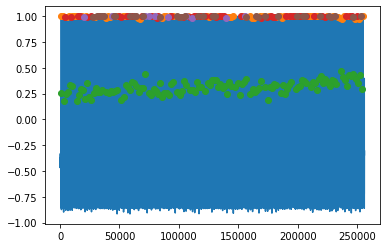

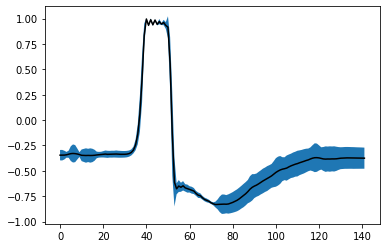

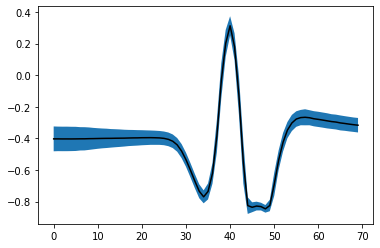

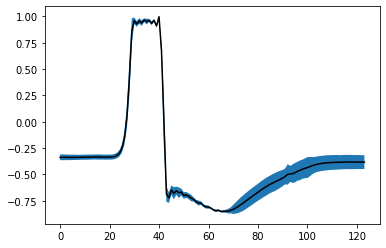

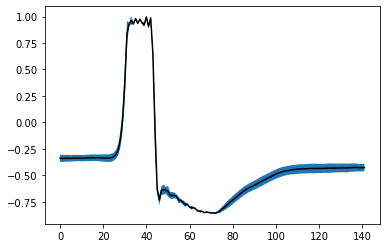

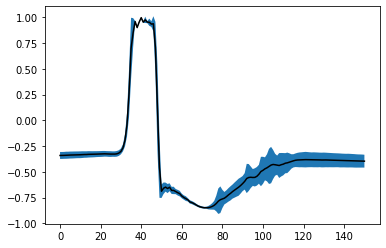

81
validation/097_Panama_2014-05-17_Ruediger_Krahe_1_pulsefish.wav
0.0
extracting times
0.019560032606124877
[4.73000000e+02 1.87225342e-01 5.01708984e-01]
0.03067855942006172
rs
1.8166729820130787
1 fish
1


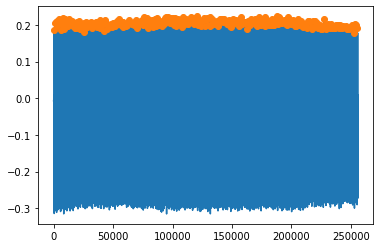

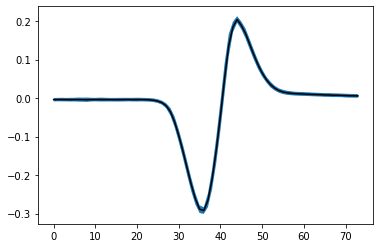

82
validation/098_Panama_2014-05-17_Ruediger_Krahe_1_pulsefish.wav
0.0
extracting times
0.017351895809173585
[3.69000000e+02 2.59429932e-01 4.98199463e-01]
0.030950126147401905
rs
1.8113123567398968
1 fish
1


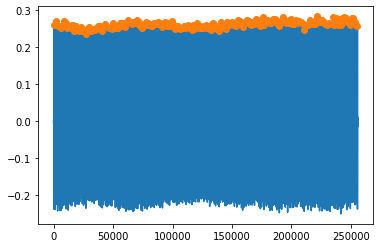

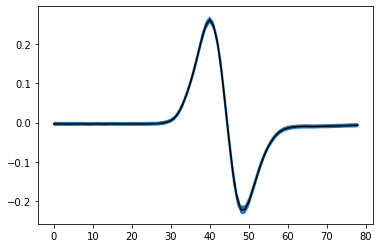

83
validation/100_Panama_2014-05-17_Ruediger_Krahe_2_pulsefish.wav
0.0
extracting times
0.012527209997177125
[2.72000000e+02 7.22045898e-02 1.10717773e-01]
0.031197325921927668
rs
0.09141238901846625
rs
0.02918175076224564
rs
0.00618315774312298
3 fish
3


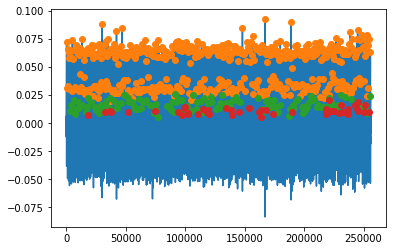

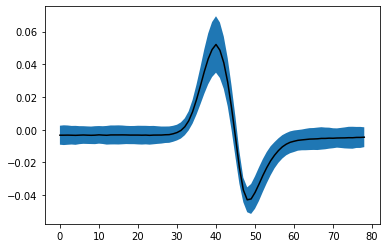

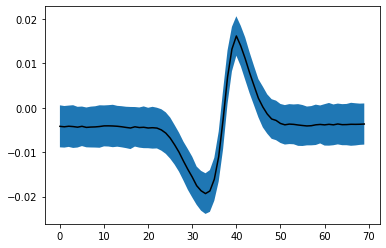

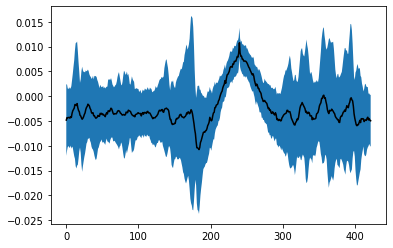

84
85
validation/102_Panama_2014-05-17_Ruediger_Krahe_1_pulsefish.wav
0.0
extracting times
0.03571284532546997
[9.42000000e+02 8.89709473e-01 1.44995117e+00]
0.03055456980383223
rs
6.501184431762186
1 fish
1


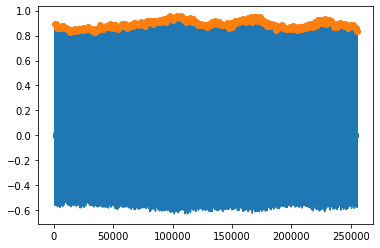

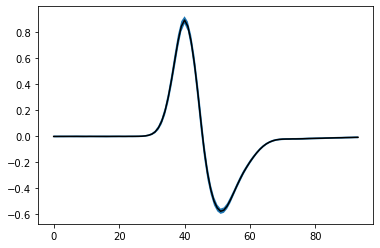

86
87
88
89
90
91
92
93
validation/113_Sanmartin_2019-10-07_Jaqcui_Goebl_1_pulsefish.wav
0.0
extracting times
0.007408735990524292
[2.70000000e+01 3.81469727e-03 1.26953125e-02]
0.02725745960609495
rs
0.09910245605034991
rs
0.005430360131338051
rs
0.002561509347397259
2 fish
2


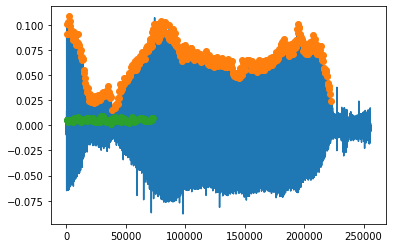

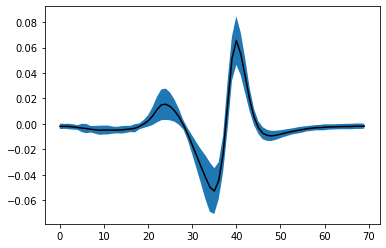

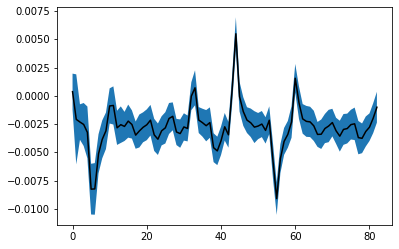

94
validation/114_Sanmartin_2019-10-07_Jaqcui_Goebl_1_pulsefish.wav
0.0
extracting times
0.010230498631795247
[1.15000000e+02 9.46044922e-04 1.40686035e-02]
0.020298299112358757
rs
0.00335842195143449
rs
0.0047198172999860935
rs
0.01706005649902527
1 fish
1


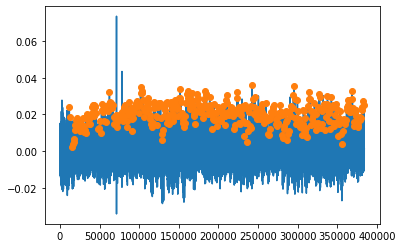

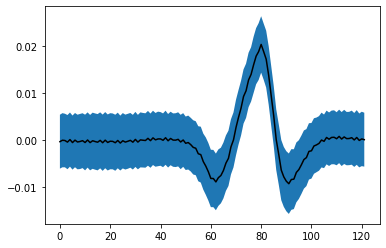

95
validation/115_Sanmartin_2019-10-07_Jaqcui_Goebl_1_pulsefish.wav
0.0
extracting times
0.012298742612202962
[8.13000000e+02 8.07495117e-02 1.40167236e-01]
0.02083323882252129
rs
0.27123590229943806
rs
0.004602678129211856
1 fish
1


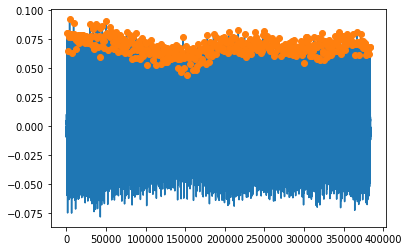

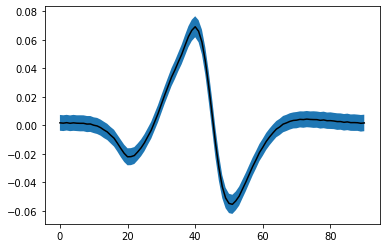

96
validation/117_Sanmartin_2019-10-09_Jaqcui_Goebl_1_pulsefish.wav


UserWarning: not enough data (data=7.1435s, win=8s)

In [6]:
%matplotlib inline

# pulse extraction:
for i,filename in enumerate(filenames):
    print(i)
    if 'wavefish' not in filename:
        print(filename)
        channel = 0
        raw_data, samplerate, unit = load_data(filename, channel)

        # best_window:
        data, clipped = best_window(raw_data, samplerate, win_size=8.0)
        
        print(clipped)
        if clipped < 0.1:

            # extract fish
            mean_eods, eod_std, eod_times = extract_pulsefish(data, samplerate)

            print('%i fish'%len(mean_eods))
            print(len(eod_std))

            # plot fish timepoints
            plot_timepoints(data,eod_times)

            # plot fish eods
            plot_eods(mean_eods,eod_std)

In [ ]:
for i in range(-50,-1):
    plt.figure()
    plt.plot(eod_times[i],mean_eods[i])
    plt.scatter(pk[pk in eod_times[i]],data[pk in eod_times[i]])
    #plt.scatter(tr[(tr>eod_times[i]-pw*samplerate/2)&(tr<eod_times[i]+pw*samplerate/2)],data[tr[(tr>eod_times[i]-pw*samplerate/2)&(tr<eod_times[i]+pw*samplerate/2)]])
    plt.show()

In [ ]:
mean_eods = normalize(mean_eods)

In [ ]:
pca = PCA(10).fit(mean_eods).transform(mean_eods)
c = DBSCAN(eps=0.2).fit(pca)

In [ ]:
for j in [1,2,4,8]:
    idx_arr = np.mean(eod_times,axis=1)
    mean_eods = np.stack([data[int(idx-pw*samplerate/j):int(idx+pw*samplerate/j)] for idx in idx_arr])

    for i in np.unique(c.labels_):
        print(i)

        plt.figure()
        #plt.plot(mean_eods[c.labels_== i].T)
        m = np.mean(mean_eods[c.labels_== i],axis=0)
        v = np.std(mean_eods[c.labels_== i],axis=0)
        plt.plot(m,c='k')
        plt.fill_between(range(len(m)), m-v, m+v)

        # change window size so this value is optimal:
        print(np.var(m)/np.mean(v))

        #plt.figure()
        #plt.plot(eod_times[c.labels_==i][:-1],1/np.diff(eod_times[c.labels_==i],axis=0))

In [ ]:
plt.figure()
%matplotlib notebook

p_times = np.mean(eod_times,axis=1) + 1

cols = ['b','g','r','k']
plt.plot(data,c='k')

for i in np.unique(c.labels_):
    plt.plot(p_times[c.labels_==i],data[p_times[c.labels_==i].astype('int')],'o',c=cols[i])

In [ ]:
transformer = SparseRandomProjection(n_components=10)
X_new = transformer.fit_transform(mean_eods)
X_new.shape

c = DBSCAN(eps=0.05).fit(X_new)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

for l in np.unique(c.labels_):
    ax1.scatter(X_new[c.labels_==l,0],X_new[c.labels_==l,1],c=cols[l])

def onclick(event):
    ax2.cla()
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))
    pos = np.argmin(np.linalg.norm(X_new - [event.xdata,event.ydata],axis=1))
    ax2.plot(mean_eods[pos])
    plt.draw()    

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [ ]:
c = DBSCAN(eps=0.03).fit(mean_eods)

fig, (ax1, ax2) = plt.subplots(1,2)

for l in np.unique(c.labels_):
    ax1.scatter(X_new[c.labels_==l,0],X_new[c.labels_==l,1],c=cols[l])

def onclick(event):
    ax2.cla()
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))
    pos = np.argmin(np.linalg.norm(X_new - [event.xdata,event.ydata],axis=1))
    ax2.plot(mean_eods[pos])
    plt.draw()    

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [ ]:
pca = PCA(2).fit(mean_eods).transform(mean_eods)
c = DBSCAN(eps=0.005).fit(pca)

transformer = SparseRandomProjection(n_components=10)
pca = transformer.fit_transform(mean_eods)

fig, (ax1, ax2) = plt.subplots(1,2)

for l in np.unique(c.labels_):
    ax1.scatter(pca[c.labels_==l,0],pca[c.labels_==l,1],c=cols[l])

def onclick(event):
    ax2.cla()
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))
    pos = np.argmin(np.linalg.norm(pca[:,:2] - [event.xdata,event.ydata],axis=1))
    ax2.plot(mean_eods[pos])
    plt.draw()    

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [ ]:
pca = PCA(10,whiten=True).fit(mean_eods).transform(mean_eods)
c = DBSCAN(eps=1.5).fit(pca)

fig, (ax1, ax2) = plt.subplots(1,2)

for l in np.unique(c.labels_):
    ax1.scatter(pca[c.labels_==l,0],pca[c.labels_==l,1])

def onclick(event):
    ax2.cla()
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))
    pos = np.argmin(np.linalg.norm(pca[:,:2] - [event.xdata,event.ydata],axis=1))
    ax2.plot(mean_eods[pos])
    plt.draw()    

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [ ]:
from sklearn.decomposition import KernelPCA

pca = KernelPCA(kernel='rbf',n_components=2).fit(mean_eods).transform(mean_eods)
c = DBSCAN(eps=0.001).fit(pca)

fig, (ax1, ax2) = plt.subplots(1,2)

for l in np.unique(c.labels_):
    ax1.scatter(pca[c.labels_==l,0],pca[c.labels_==l,1],c=cols[l])

def onclick(event):
    ax2.cla()
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))
    pos = np.argmin(np.linalg.norm(pca[:,:2] - [event.xdata,event.ydata],axis=1))
    ax2.plot(mean_eods[pos])
    plt.draw()    

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [ ]:
isomap = Isomap(n_components=2, n_jobs = 4, n_neighbors = 5)
isomap.fit(mean_eods)
X_isomap = isomap.transform(mean_eods)

In [ ]:
from sklearn.decomposition import KernelPCA

pca = X_isomap
c = DBSCAN(eps=0.01).fit(pca)

fig, (ax1, ax2) = plt.subplots(1,2)

for l in np.unique(c.labels_):
    ax1.scatter(pca[c.labels_==l,0],pca[c.labels_==l,1],c=cols[l])

def onclick(event):
    ax2.cla()
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))
    pos = np.argmin(np.linalg.norm(pca[:,:2] - [event.xdata,event.ydata],axis=1))
    ax2.plot(mean_eods[pos])
    plt.draw()    

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [ ]:
fica = FastICA(n_components=154, algorithm = 'parallel',whiten = True,max_iter = 100,  random_state=2019)
X_fica = fica.fit_transform(mean_eods)
X_fica_reconst = fica.inverse_transform(X_fica)

In [ ]:
pca = X_fica_reconst
c = DBSCAN(eps=0.01).fit(pca)

fig, (ax1, ax2) = plt.subplots(1,2)

for l in np.unique(c.labels_):
    ax1.scatter(pca[c.labels_==l,0],pca[c.labels_==l,1])

def onclick(event):
    ax2.cla()
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))
    pos = np.argmin(np.linalg.norm(pca[:,:2] - [event.xdata,event.ydata],axis=1))
    ax2.plot(mean_eods[pos])
    plt.draw()    

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [ ]:
tsne = TSNE(n_components=3, learning_rate=300, perplexity = 30, early_exaggeration = 12, init = 'random')
X_tsne = tsne.fit_transform(mean_eods)

In [ ]:
pca = X_tsne 
c = DBSCAN(eps=3).fit(pca)

cols = ['r','g','b','y','m','c','k']

fig, (ax1, ax2) = plt.subplots(1,2)

for l in np.unique(c.labels_):
    ax1.scatter(pca[c.labels_==l,0],pca[c.labels_==l,1],c=cols[l])

def onclick(event):
    ax2.cla()
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))
    pos = np.argmin(np.linalg.norm(pca[:,:2] - [event.xdata,event.ydata],axis=1))
    ax2.plot(mean_eods[pos])
    plt.draw()    

cid = fig.canvas.mpl_connect('button_press_event', onclick)